<a href="https://colab.research.google.com/github/NaomiInbal/anomaly-detection-and-trajectory-classification/blob/master/creating_missile_trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missile Trajectory Physical Model Simulation
In this section we will create a missile trajectory physical simulation. To do so, we'll define the necessary equations we need in order to proceed with this process:

(1)
$$
F⃗_{net}=F⃗_{Thrust} - F⃗_{Drag} - F⃗_g
$$

(2)
$$
m\cdot \frac{d^2z}{dt^2} = F⃗_{Thrust}(t) - F⃗_{Drag}(z,{ż}^2) - F⃗_g(z,t)
$$




*Net force is the sum of all forces acting on an object. The net force can be calculated using Newton's second law, which states that F = ma
F Thrust - דחף המנוע
F Drag - כוח גרר (חיכוך) https://en.wikipedia.org/wiki/Drag_(physics)

The equations given above defines an elementary physical model, based on Newton's 2nd Law (1),(F = m*a) i.e., the net force applied by the missile is proportional to the force applied by the engine's thrust, reducing the drag of the missile and the force of gravity.
One thing we have to take in account is that the different componenets in eq #1 are dependent of each other, forcing us to take a differential approach to solve it.

##Assumptions


1. Most rockets reaching orbit are liquid-fueled, except for the Space Shuttle.
In this project, we assume constant thrust during ascent, with thrust depending only on time. The model acknowledges its one-dimensional nature, simplifying the vertical thrust component and accounting for potential aerodynamic lift in non-zero angle launches.

2. The rocket experiences drag from atmospheric and wave components. Atmospheric drag, a form of parasitic drag, opposes motion due to skin friction. The equation for atmospheric skin friction drag is expressed with air density (ρ), rocket velocity (v), drag coefficient (CD), and cross-sectional area (A). Assuming CD = 0.75, representing a shape between a cylinder and a cone. Air density calculation involves the ideal gas law for altitudes under 86 km, considering gas constant (R), and molar mass of air (M). Atmospheric temperature and pressure, dependent on altitude, are determined by barometric equations.

3.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import pandas as pd
from google.colab import drive


## Physical Universal Constants



In [ ]:
# Universal constants
G = 6.674e-11  # gravitational constant
M_earth = 5.972e24  # mass of the Earth
r = 6371000 # radius of the Earth in meters
mol = 0.029  # molar mass of air
R = 8.314  # gas constant
P0 = 101325  # standard pressure (Pa), sea level
T0 = 300  # Israel temperature (K), sea level
rho0 = (mol * P0) / (R * T0)  # air density, sea level
g0 = 9.81  # gravitational acceleration, sea level


## Local Constants

In [ ]:
# Local constants

FT = 560000  # rocket thrust, in Newtons
d = 1.7  # rocket diameter, in meters
A = np.pi * (d / 2) ** 2  # rocket cross-sectional area
L = 0  # rocket length, in meters
empty = 3120  # mass when fuel is expended, in kg ("dry mass")
Isp = 221  # specific impulse, in seconds
dm = FT / (g0 * Isp)  # mass flow rate, dm/dt


# Initial Conditions
m0 = 46760  # initial mass, in kg ("wet mass")
C0 = 0.75  # drag coefficient
z0 = 1  # initial altitude
v0 = 0  # initial velocity


# Euler-Cromer Method
dt = 0.1  # time step

v = v0
z = z0
V = [v]
Z = [z]
m = m0
Rho = [rho0]
T = [T0]
P = [P0]
M = [m]
Thrust = [FT / m]
Drag = [0]
g = g0
grav = [g]

nextstage = 0
tmax = 500

# Define auxiliary functions
The following functions will help us simulate the environmental changes as a function of the height.



In order to simulate the changes in temperature as a function of given height, we used the following table:
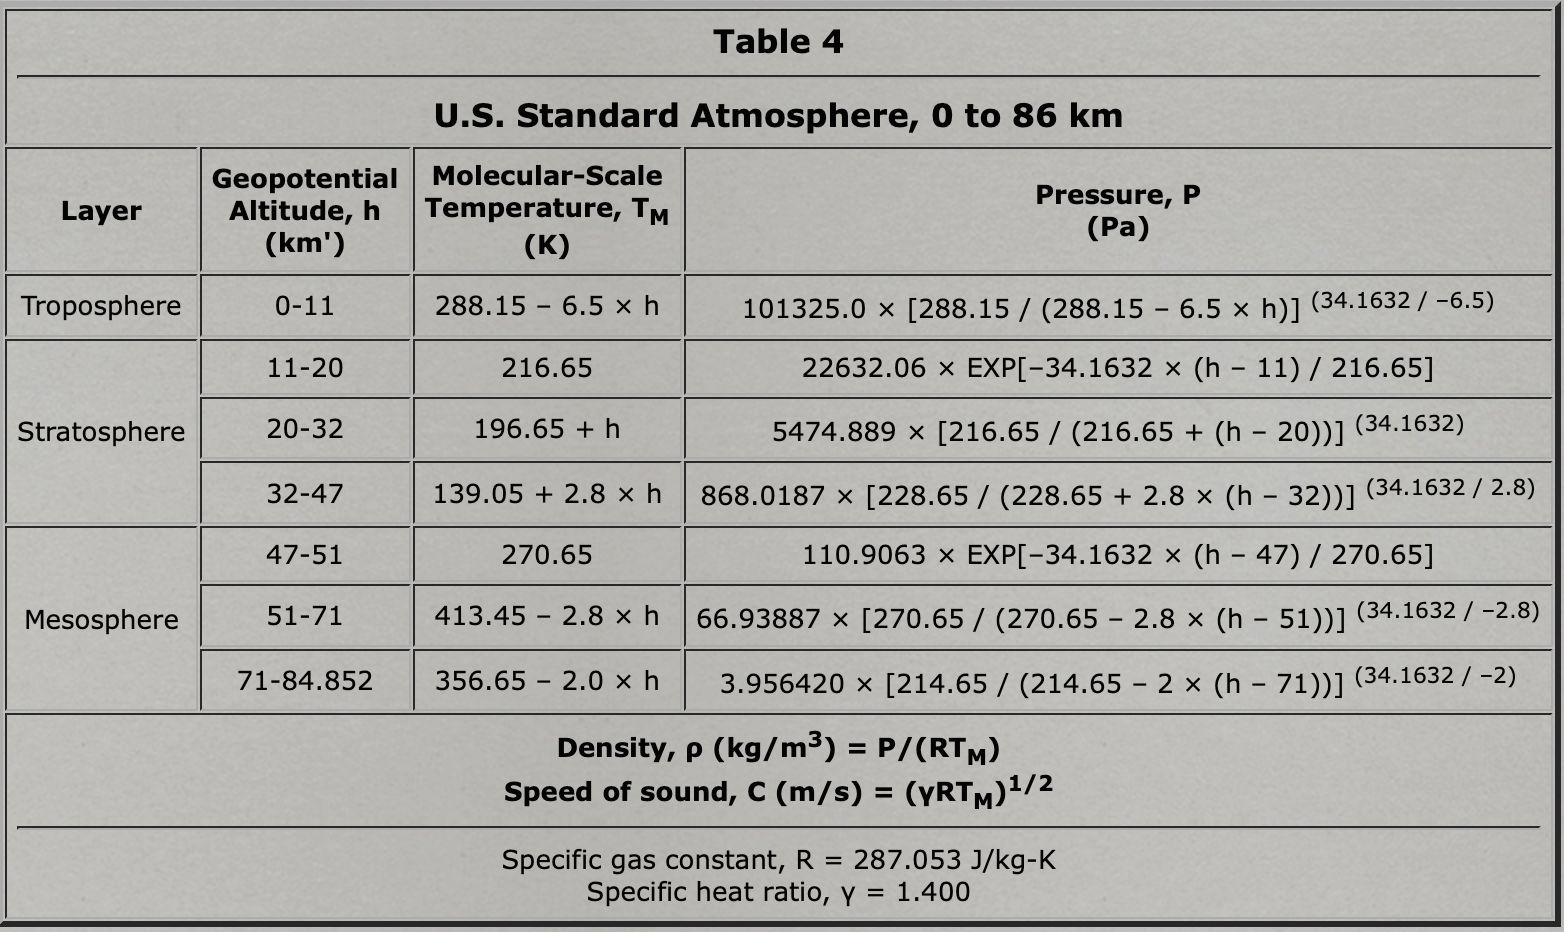

The provided Python implementation is applying the Prandtl-Glauert rule, which is often used to correct the drag coefficient $C_d$ values for subsonic flow when approaching or reaching the speed of sound $Mach = 1$. This rule is an approximation and is valid for \(Mach < 1\).

The formula implemented in the code is:
$$
C_d = \frac{C_0}{\sqrt{1 - Mach^2}}
$$
where:


- $C_d$ is the corrected drag coefficient,
- $C_0$ is the drag coefficient at zero velocity (assumed constant, not defined in the provided code),
- $Mach$ is the Mach number.

This formula essentially adjusts the drag coefficient as the rocket approaches the speed of sound to account for the compressibility effects on aerodynamics.

However, it's crucial to note that this correction is specific to subsonic flows. For supersonic or transonic flows $Mach > 1$, different formulations and considerations are needed.



In [ ]:
meter_to_km = lambda z: z/1000


def gaussian_noise(*args, noise_factor=0.01):
    """
    Add proportional noise to each input parameter.

    Parameters:
    - args: Arbitrary number of float parameters.
    - noise_factor (float): Scaling factor for the noise.

    Returns:
    - list: List of parameters with added proportional noise.
    """
    noisy_parameters = [param * (1 + noise_factor * np.random.randn()) for param in args]
    return noisy_parameters


# Define density function
def density(z):
    """
    Calculate air density, temperature, and pressure at a given altitude using the barometric formula.

    Parameters:
    - z (float): Altitude in meters.

    Returns:
    - density (float): Air density in kg/m^3.
    - temperature (float): Temperature in Kelvin.
    - pressure (float): Pressure in Pascal.
    """

    h = meter_to_km(z)

    if   0 <= h <= 11:
        temperature = 288.15 - 6.5 * h
        pressure = 101325 * ((288.15 / (288.15 - 6.5 * h)) ** (34.1632 / -6.5))

    elif 11 < h <= 20:
        temperature = 216.65
        pressure = 22632.06 * np.exp(-34.1632 * (h - 11) / 216.65)

    elif 20 < h <= 32:
        temperature = 196.65 + 0.001 * z
        pressure = 5474.889 * ((216.65 / (216.65 + (h - 20))) ** (34.1632))

    elif 32 < h <= 47:
        temperature = 139.05 + 2.8 * h
        pressure = 868.0187 * ((228.65 / (228.65 + 2.8 * (h - 32))) ** (34.1632 / 2.8))

    elif 47 < h <= 51:
        temperature = 270.65
        pressure = 110.9063 * np.exp(-34.1632 * (h - 47) / 270.65)

    elif 51 < h <= 71:
        temperature = 413.45 - 2.8 * h
        pressure = 66.93887 * ((270.65 / (270.65 - 2.8 * (h - 51))) ** (34.1632 / -2.8))

    else:
        temperature = 356.65 - 2.0 * h
        pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))

    density = (mol * pressure) / (R * temperature)

    if 86 < h <= 91:
        pressure = np.exp(-4.22012E-08 * h ** 5 + 2.13489E-05 * h ** 4 - 4.26388E-03 * h ** 3 +
                           0.421404 * h ** 2 - 20.8270 * h + 416.225)
        density = np.exp(7.5691E-08 * h ** 5 - 3.76113E-05 * h ** 4 + 0.0074765 * h ** 3 -
                         0.743012 * h ** 2 + 36.7280 * h - 729.346)
        temperature = 186.8673
    elif 91 < h <= 100:
        pressure = np.exp(-4.22012E-08 * h ** 5 + 2.13489E-05 * h ** 4 - 4.26388E-03 * h ** 3 +
                           0.421404 * h ** 2 - 20.8270 * h + 416.225)
        density = np.exp(7.5691E-08 * h ** 5 - 3.76113E-05 * h ** 4 + 0.0074765 * h ** 3 -
                         0.743012 * h ** 2 + 36.7280 * h - 729.346)
        temperature = 263.1905 - 76.3232 * np.sqrt(1 - ((h - 91) / -19.9429) ** 2)
    elif 100 < h <= 110:
        pressure = np.exp(-4.22012E-08 * h ** 5 + 2.13489E-05 * h ** 4 - 4.26388E-03 * h ** 3 +
                           0.421404 * h ** 2 - 20.8270 * h + 416.225)
        density = np.exp(7.5691E-08 * h ** 5 - 3.76113E-05 * h ** 4 + 0.0074765 * h ** 3 -
                         0.743012 * h ** 2 + 36.7280 * h - 729.346)
        temperature = 263.1905 - 76.3232 * np.sqrt(1 - ((h - 91) / -19.9429) ** 2)
    elif 110 < h <= 120:
        density = np.exp(-8.854164E-05 * h ** 3 + 0.03373254 * h ** 2 - 4.390837 * h +
                          176.5294)
        pressure = 0
        temperature = 240 + 12 * (h - 110)
    elif 120 < h <= 150:
        pressure = 0
        density = np.exp(3.661771E-07 * h ** 4 - 2.154344E-04 * h ** 3 + 0.04809214 * h ** 2 -
                         4.884744 * h + 172.3597)
        temperature = 1000 - 640 * np.exp(-0.01875 * (h - 120) * (6356.766 + 120) / (6356.766 + h))
    elif 150 < h:  # && h <= 200
        pressure = 0
        density = 2.0763e-09
        temperature = 1000 - 640 * np.exp(-0.01875 * (h - 120) * (6356.766 + 120) / (6356.766 + h))
    return density, temperature, pressure


# Define Drag Coefficient Function
def drag_coefficient(velocity, temp):
    Cd = 0.0  # Initialize Cd before the conditional statements
    cs = np.sqrt(1.4 * 287 * temp)  # sound speed as a function of temperature
    Mach = velocity / cs  # Mach number
    if Mach < 1:
        Cd = C0 / np.sqrt(1 - Mach ** 2)  # Prandtl-Glauert Rule
    elif Mach == 1:
        Mach = 0.99999  # eliminate the singularity
        Cd = C0 / np.sqrt(1 - Mach ** 2)
    elif Mach > 1:
        Cd = C0 / np.sqrt(Mach ** 2 - 1)
    return Cd

# Save the data


In [ ]:
from google.colab import drive
import os
import pandas as pd

def save_data_to_csv(data, file_path, drive_folder):
    """
    Save the provided data dictionary to a CSV file in Google Drive.

    Parameters:
    - data (dict): Dictionary containing data.
    - file_path (str): File path to save the CSV file.
    - drive_folder (str): Folder in Google Drive where you want to save the file.

    Returns:
    None
    """
    # Check if Google Drive is already mounted
    if not os.path.exists('/content/drive/MyDrive'):
        # Mount Google Drive
        drive.mount('/content/drive')

    # Create the full path to the folder in Google Drive
    folder_path = os.path.join('/content/drive/MyDrive', drive_folder)

    # Check if the folder exists, create it if not
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{drive_folder}' created in MyDrive.")

    # Create the full path to the file in Google Drive
    full_path = os.path.join(folder_path, file_path)

    # Create DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv(full_path, index=False)

    print(f"Data saved to: {full_path}")


In [ ]:

def zip_and_transfer(folder_path, zip_file_name, destination_folder):
    """
    Create a zip file containing all existing files in the given folder
    and transfer it to a new destination folder.

    Parameters:
    - folder_path (str): Path to the folder containing files to be zipped.
    - zip_file_name (str): Name of the zip file to be created.
    - destination_folder (str): Path to the folder where the zip file will be transferred.

    Returns:
    None
    """
    zip_file_path = os.path.join(destination_folder, zip_file_name)

    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname=arcname)

In [ ]:
def plot_graphs(tmax, dt, V, Z, M, Thrust, grav, Rho, T, P, Drag):
    """
    Plot various aspects of a missile's trajectory and forces over time.

    Parameters:
    - tmax (float): Maximum time of the simulation.
    - dt (float): Time step for the simulation.
    - V (numpy.ndarray): Array containing missile velocities at each time step.
    - Z (numpy.ndarray): Array containing missile altitudes at each time step.
    - M (numpy.ndarray): Array containing missile masses at each time step.
    - Thrust (numpy.ndarray): Array containing thrust forces at each time step.
    - grav (numpy.ndarray): Array containing gravitational accelerations at each time step.
    - Rho (numpy.ndarray): Array containing air densities at each time step.
    - T (numpy.ndarray): Array containing temperatures at each time step.
    - P (numpy.ndarray): Array containing pressures at each time step.
    - Drag (numpy.ndarray): Array containing drag forces at each time step.


    Plots:
    1. Missile altitude over time.
    2. Missile velocity over time.
    3. Thrust and drag forces over time.
    4. Gravitational acceleration over time.
    """

    # Create time array
    t = np.arange(0, tmax + dt, dt)

    # Plot the trajectory, forces, and density
    fig, axes = plt.subplots(4, 1, figsize=(10, 12))

    # Plot the trajectory (altitude)
    axes[0].plot(t, np.array(Z) / 1000)  # Divided by 1000 to plot in kilometers
    axes[0].set_title('Rocket altitude')
    axes[0].set_ylim([0, 1.5 * max(Z) / 1000])  # Adjust y-axis limits
    axes[0].set_xlabel('time (s)')
    axes[0].set_ylabel('altitude (km)')

    # Plot the velocity
    axes[1].plot(t, V)
    axes[1].set_title('Rocket velocity')
    axes[1].set_ylim([1.5 * min(V), 1.5 * max(V)])  # Adjust y-axis limits
    axes[1].set_xlabel('time (s)')
    axes[1].set_ylabel('velocity (m/s)')

    # Plot the forces (Thrust and Drag)
    axes[2].plot(t, np.array(Thrust) * (np.array(M)), label='Thrust')
    axes[2].plot(t, np.array(Drag) * np.array(M), label='Drag')
    axes[2].set_title('Thrust and Drag forces')
    axes[2].set_xlabel('time (s)')
    axes[2].set_ylabel('force (kN)')
    axes[2].legend()

    # Plot the gravitational acceleration
    axes[3].plot(t, grav)
    axes[3].set_title('Gravitational acceleration')
    axes[3].set_xlabel('time (s)')
    axes[3].set_ylabel('g (m/s^2)')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()



## Trajectory Simulator
### Generating normal trajectories

In [ ]:
def generating_normal_trajectories(num_samples=2000):
    """
    Simulate rocket launches with varying parameters and save the data to CSV files.

    Parameters:
    - num_samples (int): Number of rocket launch simulations to perform.

    Returns:
    - None

    Simulation Parameters:
    - FT (float): Rocket thrust in Newtons.
    - d (float): Rocket diameter in meters.
    - A (float): Rocket cross-sectional area calculated from the diameter.
    - L (float): Rocket length in meters (currently set to 0, no effect in the simulation).
    - empty (float): Mass when fuel is expended (dry mass) in kg.
    - Isp (float): Specific impulse in seconds.
    - dm (float): Mass flow rate calculated from thrust and specific impulse.
    - m0 (float): Initial mass (wet mass) of the rocket in kg.
    - C0 (float): Drag coefficient (currently set to 0.75, can be modified).
    - z0 (float): Initial altitude of the rocket.
    - v0 (float): Initial velocity of the rocket.
    - dt (float): Time step for the simulation.

    Outputs:
    - CSV files containing simulation data for each sample. Each CSV file includes columns:
      - Velocity[m/s], Altitude[m], Thrust[N], Gravitational Acceleration[m/s^2],
      - Temperature[K], Pressure[PSI], Drag[N], Mass[Kg], Density, Label.


    - The simulation uses the Euler-Cromer method for numerical integration.
    - Air density and drag coefficient are subject to Gaussian noise.
    - Rocket parameters can be modified for different scenarios.


    """
    for i in range(num_samples):
        # TODO: Consider making these variables non-deterministic
        FT = 560000  # rocket thrust, in Newtons
        d = 1.7  # rocket diameter, in meters
        A = np.pi * (d / 2) ** 2  # rocket cross-sectional area
        L = 0  # rocket length, in meters
        empty = 3120  # mass when fuel is expended, in kg ("dry mass")
        Isp = 221  # specific impulse, in seconds
        dm = FT / (g0 * Isp)  # mass flow rate, dm/dt


        # Initial Conditions
        m0 = 46760  # initial mass, in kg ("wet mass")
        C0 = 0.75  # drag coefficient, see notes
        z0 = 1  # initial altitude
        v0 = 0  # initial velocity


        # Euler-Cromer Method
        dt = 0.1  # time step

        v = v0
        z = z0
        V = [v]
        Z = [z]
        m = m0
        Rho = [rho0]
        T = [T0]
        P = [P0]
        M = [m]
        Thrust = [FT / m]
        Drag = [0]
        g = g0
        grav = [g]

        nextstage = 0
        tmax = 500

        print(f"Starting with sample #{i}")
        for t in np.arange(dt, tmax + dt, dt):
            g = (G * M_earth) / ((z + 6371000) ** 2)  # gravitational acceleration, g(z)
            m = m - (dm * dt)  # changing mass, m(t)
            rho, temp, press = density(z)
            rho, temp, press = gaussian_noise(rho, temp, press)

            # changing air density by barometric formula, rho(z)
            Cd = gaussian_noise(drag_coefficient(v, temp))[0]

            thrust = FT / m
            drag = 0.5 * rho * (v ** 2) * Cd * A / m

            if v < 0:  # flip drag force vector if rocket falls
                drag = drag * -1

            v = v + (thrust - drag - g) * dt  # new velocity
            z = z + v * dt  # new altitude

            V.append(v)
            Z.append(z)
            M.append(m)
            grav.append(g)
            Thrust.append(thrust)
            Drag.append(drag)
            Rho.append(rho)
            T.append(temp)
            P.append(press)


            if z < 0:  # rocket crashes or fails to launch
                break
            elif m < empty:  # rocket runs out of fuel, mass becomes stable
                FT = 0
                dm = 0
                nextstage += 1
        data = {
        'Velocity[m/s]': V,
        'Altitude[m]': Z,
        'Thrust[N]': Thrust,
        'gravitation [m/s^2]': grav,
        'Temperature[K]': T,
        'Pressure[PSI]': P,
        'Drag[N]': Drag,
        'Mass[Kg]': M,
        'Density': Rho,
        'Lable': 0
        }

        dataset_dir = "/content/drive/MyDrive/MyDatasetFolder/dataset"
        if not os.path.exists(dataset_dir):
            os.makedirs(dataset_dir)
            print(f"Dataset folder created in MyDatasetFolder.")

        try:
            save_data_to_csv(data, f"dataset/{i}.csv", "MyDatasetFolder")
            print(f"Dataset {i} saved successfully.")
        except Exception as e:
            print(f"Failed to save dataset {i}. Error: {e}")

generating_normal_trajectories(num_samples=2000)

Starting with sample #0
Dataset folder created in MyDatasetFolder.
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/0.csv
Dataset 0 saved successfully.
Starting with sample #1


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1.csv
Dataset 1 saved successfully.
Starting with sample #2
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/2.csv
Dataset 2 saved successfully.
Starting with sample #3


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/3.csv
Dataset 3 saved successfully.
Starting with sample #4
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/4.csv
Dataset 4 saved successfully.
Starting with sample #5


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/5.csv
Dataset 5 saved successfully.
Starting with sample #6
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/6.csv
Dataset 6 saved successfully.
Starting with sample #7


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/7.csv
Dataset 7 saved successfully.
Starting with sample #8
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/8.csv
Dataset 8 saved successfully.
Starting with sample #9


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/9.csv
Dataset 9 saved successfully.
Starting with sample #10
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/10.csv
Dataset 10 saved successfully.
Starting with sample #11


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/11.csv
Dataset 11 saved successfully.
Starting with sample #12
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/12.csv
Dataset 12 saved successfully.
Starting with sample #13


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/13.csv
Dataset 13 saved successfully.
Starting with sample #14
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/14.csv
Dataset 14 saved successfully.
Starting with sample #15


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/15.csv
Dataset 15 saved successfully.
Starting with sample #16
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/16.csv
Dataset 16 saved successfully.
Starting with sample #17


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/17.csv
Dataset 17 saved successfully.
Starting with sample #18


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/18.csv
Dataset 18 saved successfully.
Starting with sample #19
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/19.csv
Dataset 19 saved successfully.
Starting with sample #20


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/20.csv
Dataset 20 saved successfully.
Starting with sample #21
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/21.csv
Dataset 21 saved successfully.
Starting with sample #22


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/22.csv
Dataset 22 saved successfully.
Starting with sample #23
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/23.csv
Dataset 23 saved successfully.
Starting with sample #24


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/24.csv
Dataset 24 saved successfully.
Starting with sample #25
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/25.csv
Dataset 25 saved successfully.
Starting with sample #26


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/26.csv
Dataset 26 saved successfully.
Starting with sample #27
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/27.csv
Dataset 27 saved successfully.
Starting with sample #28


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/28.csv
Dataset 28 saved successfully.
Starting with sample #29
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/29.csv
Dataset 29 saved successfully.
Starting with sample #30


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/30.csv
Dataset 30 saved successfully.
Starting with sample #31
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/31.csv
Dataset 31 saved successfully.
Starting with sample #32


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/32.csv
Dataset 32 saved successfully.
Starting with sample #33


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/33.csv
Dataset 33 saved successfully.
Starting with sample #34


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/34.csv
Dataset 34 saved successfully.
Starting with sample #35


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/35.csv
Dataset 35 saved successfully.
Starting with sample #36


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/36.csv
Dataset 36 saved successfully.
Starting with sample #37


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/37.csv
Dataset 37 saved successfully.
Starting with sample #38


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/38.csv
Dataset 38 saved successfully.
Starting with sample #39


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/39.csv
Dataset 39 saved successfully.
Starting with sample #40


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/40.csv
Dataset 40 saved successfully.
Starting with sample #41


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/41.csv
Dataset 41 saved successfully.
Starting with sample #42


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/42.csv
Dataset 42 saved successfully.
Starting with sample #43


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/43.csv
Dataset 43 saved successfully.
Starting with sample #44


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/44.csv
Dataset 44 saved successfully.
Starting with sample #45


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/45.csv
Dataset 45 saved successfully.
Starting with sample #46


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/46.csv
Dataset 46 saved successfully.
Starting with sample #47


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/47.csv
Dataset 47 saved successfully.
Starting with sample #48


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/48.csv
Dataset 48 saved successfully.
Starting with sample #49


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/49.csv
Dataset 49 saved successfully.
Starting with sample #50


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/50.csv
Dataset 50 saved successfully.
Starting with sample #51


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/51.csv
Dataset 51 saved successfully.
Starting with sample #52


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/52.csv
Dataset 52 saved successfully.
Starting with sample #53


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/53.csv
Dataset 53 saved successfully.
Starting with sample #54


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/54.csv
Dataset 54 saved successfully.
Starting with sample #55


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/55.csv
Dataset 55 saved successfully.
Starting with sample #56


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/56.csv
Dataset 56 saved successfully.
Starting with sample #57


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/57.csv
Dataset 57 saved successfully.
Starting with sample #58


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/58.csv
Dataset 58 saved successfully.
Starting with sample #59


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/59.csv
Dataset 59 saved successfully.
Starting with sample #60


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/60.csv
Dataset 60 saved successfully.
Starting with sample #61


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/61.csv
Dataset 61 saved successfully.
Starting with sample #62


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/62.csv
Dataset 62 saved successfully.
Starting with sample #63


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/63.csv
Dataset 63 saved successfully.
Starting with sample #64


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/64.csv
Dataset 64 saved successfully.
Starting with sample #65


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/65.csv
Dataset 65 saved successfully.
Starting with sample #66


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/66.csv
Dataset 66 saved successfully.
Starting with sample #67


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/67.csv
Dataset 67 saved successfully.
Starting with sample #68


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/68.csv
Dataset 68 saved successfully.
Starting with sample #69


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/69.csv
Dataset 69 saved successfully.
Starting with sample #70
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/70.csv
Dataset 70 saved successfully.
Starting with sample #71


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/71.csv
Dataset 71 saved successfully.
Starting with sample #72
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/72.csv
Dataset 72 saved successfully.
Starting with sample #73


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/73.csv
Dataset 73 saved successfully.
Starting with sample #74
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/74.csv
Dataset 74 saved successfully.
Starting with sample #75


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/75.csv
Dataset 75 saved successfully.
Starting with sample #76
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/76.csv
Dataset 76 saved successfully.
Starting with sample #77


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/77.csv
Dataset 77 saved successfully.
Starting with sample #78
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/78.csv
Dataset 78 saved successfully.
Starting with sample #79


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/79.csv
Dataset 79 saved successfully.
Starting with sample #80
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/80.csv
Dataset 80 saved successfully.
Starting with sample #81


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/81.csv
Dataset 81 saved successfully.
Starting with sample #82
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/82.csv
Dataset 82 saved successfully.
Starting with sample #83


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/83.csv
Dataset 83 saved successfully.
Starting with sample #84
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/84.csv
Dataset 84 saved successfully.
Starting with sample #85


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/85.csv
Dataset 85 saved successfully.
Starting with sample #86
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/86.csv
Dataset 86 saved successfully.
Starting with sample #87


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/87.csv
Dataset 87 saved successfully.
Starting with sample #88
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/88.csv
Dataset 88 saved successfully.
Starting with sample #89


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/89.csv
Dataset 89 saved successfully.
Starting with sample #90


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/90.csv
Dataset 90 saved successfully.
Starting with sample #91


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/91.csv
Dataset 91 saved successfully.
Starting with sample #92


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/92.csv
Dataset 92 saved successfully.
Starting with sample #93


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/93.csv
Dataset 93 saved successfully.
Starting with sample #94


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/94.csv
Dataset 94 saved successfully.
Starting with sample #95


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/95.csv
Dataset 95 saved successfully.
Starting with sample #96


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/96.csv
Dataset 96 saved successfully.
Starting with sample #97


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/97.csv
Dataset 97 saved successfully.
Starting with sample #98


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/98.csv
Dataset 98 saved successfully.
Starting with sample #99
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/99.csv
Dataset 99 saved successfully.
Starting with sample #100


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/100.csv
Dataset 100 saved successfully.
Starting with sample #101
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/101.csv
Dataset 101 saved successfully.
Starting with sample #102


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/102.csv
Dataset 102 saved successfully.
Starting with sample #103
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/103.csv
Dataset 103 saved successfully.
Starting with sample #104


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/104.csv
Dataset 104 saved successfully.
Starting with sample #105
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/105.csv
Dataset 105 saved successfully.
Starting with sample #106


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/106.csv
Dataset 106 saved successfully.
Starting with sample #107
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/107.csv
Dataset 107 saved successfully.
Starting with sample #108


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/108.csv
Dataset 108 saved successfully.
Starting with sample #109
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/109.csv
Dataset 109 saved successfully.
Starting with sample #110


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/110.csv
Dataset 110 saved successfully.
Starting with sample #111
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/111.csv
Dataset 111 saved successfully.
Starting with sample #112


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/112.csv
Dataset 112 saved successfully.
Starting with sample #113
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/113.csv
Dataset 113 saved successfully.
Starting with sample #114


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/114.csv
Dataset 114 saved successfully.
Starting with sample #115
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/115.csv
Dataset 115 saved successfully.
Starting with sample #116


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/116.csv
Dataset 116 saved successfully.
Starting with sample #117
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/117.csv
Dataset 117 saved successfully.
Starting with sample #118


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/118.csv
Dataset 118 saved successfully.
Starting with sample #119
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/119.csv
Dataset 119 saved successfully.
Starting with sample #120


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/120.csv
Dataset 120 saved successfully.
Starting with sample #121
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/121.csv
Dataset 121 saved successfully.
Starting with sample #122


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/122.csv
Dataset 122 saved successfully.
Starting with sample #123
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/123.csv
Dataset 123 saved successfully.
Starting with sample #124


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/124.csv
Dataset 124 saved successfully.
Starting with sample #125
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/125.csv
Dataset 125 saved successfully.
Starting with sample #126


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/126.csv
Dataset 126 saved successfully.
Starting with sample #127
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/127.csv
Dataset 127 saved successfully.
Starting with sample #128


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/128.csv
Dataset 128 saved successfully.
Starting with sample #129
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/129.csv
Dataset 129 saved successfully.
Starting with sample #130


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/130.csv
Dataset 130 saved successfully.
Starting with sample #131
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/131.csv
Dataset 131 saved successfully.
Starting with sample #132


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/132.csv
Dataset 132 saved successfully.
Starting with sample #133
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/133.csv
Dataset 133 saved successfully.
Starting with sample #134


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/134.csv
Dataset 134 saved successfully.
Starting with sample #135
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/135.csv
Dataset 135 saved successfully.
Starting with sample #136


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/136.csv
Dataset 136 saved successfully.
Starting with sample #137
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/137.csv
Dataset 137 saved successfully.
Starting with sample #138


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/138.csv
Dataset 138 saved successfully.
Starting with sample #139
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/139.csv
Dataset 139 saved successfully.
Starting with sample #140


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/140.csv
Dataset 140 saved successfully.
Starting with sample #141
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/141.csv
Dataset 141 saved successfully.
Starting with sample #142


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/142.csv
Dataset 142 saved successfully.
Starting with sample #143
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/143.csv
Dataset 143 saved successfully.
Starting with sample #144


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/144.csv
Dataset 144 saved successfully.
Starting with sample #145
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/145.csv
Dataset 145 saved successfully.
Starting with sample #146


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/146.csv
Dataset 146 saved successfully.
Starting with sample #147
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/147.csv
Dataset 147 saved successfully.
Starting with sample #148


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/148.csv
Dataset 148 saved successfully.
Starting with sample #149
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/149.csv
Dataset 149 saved successfully.
Starting with sample #150


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/150.csv
Dataset 150 saved successfully.
Starting with sample #151
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/151.csv
Dataset 151 saved successfully.
Starting with sample #152


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/152.csv
Dataset 152 saved successfully.
Starting with sample #153
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/153.csv
Dataset 153 saved successfully.
Starting with sample #154


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/154.csv
Dataset 154 saved successfully.
Starting with sample #155
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/155.csv
Dataset 155 saved successfully.
Starting with sample #156


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/156.csv
Dataset 156 saved successfully.
Starting with sample #157
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/157.csv
Dataset 157 saved successfully.
Starting with sample #158


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/158.csv
Dataset 158 saved successfully.
Starting with sample #159
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/159.csv
Dataset 159 saved successfully.
Starting with sample #160


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/160.csv
Dataset 160 saved successfully.
Starting with sample #161
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/161.csv
Dataset 161 saved successfully.
Starting with sample #162


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/162.csv
Dataset 162 saved successfully.
Starting with sample #163
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/163.csv
Dataset 163 saved successfully.
Starting with sample #164


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/164.csv
Dataset 164 saved successfully.
Starting with sample #165
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/165.csv
Dataset 165 saved successfully.
Starting with sample #166


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/166.csv
Dataset 166 saved successfully.
Starting with sample #167
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/167.csv
Dataset 167 saved successfully.
Starting with sample #168


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/168.csv
Dataset 168 saved successfully.
Starting with sample #169


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/169.csv
Dataset 169 saved successfully.
Starting with sample #170


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/170.csv
Dataset 170 saved successfully.
Starting with sample #171


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/171.csv
Dataset 171 saved successfully.
Starting with sample #172


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/172.csv
Dataset 172 saved successfully.
Starting with sample #173


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/173.csv
Dataset 173 saved successfully.
Starting with sample #174


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/174.csv
Dataset 174 saved successfully.
Starting with sample #175


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/175.csv
Dataset 175 saved successfully.
Starting with sample #176


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/176.csv
Dataset 176 saved successfully.
Starting with sample #177
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/177.csv
Dataset 177 saved successfully.
Starting with sample #178


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/178.csv
Dataset 178 saved successfully.
Starting with sample #179
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/179.csv
Dataset 179 saved successfully.
Starting with sample #180


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/180.csv
Dataset 180 saved successfully.
Starting with sample #181
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/181.csv
Dataset 181 saved successfully.
Starting with sample #182


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/182.csv
Dataset 182 saved successfully.
Starting with sample #183
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/183.csv
Dataset 183 saved successfully.
Starting with sample #184


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/184.csv
Dataset 184 saved successfully.
Starting with sample #185
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/185.csv
Dataset 185 saved successfully.
Starting with sample #186


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/186.csv
Dataset 186 saved successfully.
Starting with sample #187
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/187.csv
Dataset 187 saved successfully.
Starting with sample #188


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/188.csv
Dataset 188 saved successfully.
Starting with sample #189
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/189.csv
Dataset 189 saved successfully.
Starting with sample #190


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/190.csv
Dataset 190 saved successfully.
Starting with sample #191
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/191.csv
Dataset 191 saved successfully.
Starting with sample #192


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/192.csv
Dataset 192 saved successfully.
Starting with sample #193
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/193.csv
Dataset 193 saved successfully.
Starting with sample #194


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/194.csv
Dataset 194 saved successfully.
Starting with sample #195
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/195.csv
Dataset 195 saved successfully.
Starting with sample #196


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/196.csv
Dataset 196 saved successfully.
Starting with sample #197
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/197.csv
Dataset 197 saved successfully.
Starting with sample #198


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/198.csv
Dataset 198 saved successfully.
Starting with sample #199
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/199.csv
Dataset 199 saved successfully.
Starting with sample #200


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/200.csv
Dataset 200 saved successfully.
Starting with sample #201
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/201.csv
Dataset 201 saved successfully.
Starting with sample #202


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/202.csv
Dataset 202 saved successfully.
Starting with sample #203
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/203.csv
Dataset 203 saved successfully.
Starting with sample #204


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/204.csv
Dataset 204 saved successfully.
Starting with sample #205
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/205.csv
Dataset 205 saved successfully.
Starting with sample #206


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/206.csv
Dataset 206 saved successfully.
Starting with sample #207
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/207.csv
Dataset 207 saved successfully.
Starting with sample #208


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/208.csv
Dataset 208 saved successfully.
Starting with sample #209
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/209.csv
Dataset 209 saved successfully.
Starting with sample #210


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/210.csv
Dataset 210 saved successfully.
Starting with sample #211
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/211.csv
Dataset 211 saved successfully.
Starting with sample #212


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/212.csv
Dataset 212 saved successfully.
Starting with sample #213
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/213.csv
Dataset 213 saved successfully.
Starting with sample #214


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/214.csv
Dataset 214 saved successfully.
Starting with sample #215
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/215.csv
Dataset 215 saved successfully.
Starting with sample #216


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/216.csv
Dataset 216 saved successfully.
Starting with sample #217
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/217.csv
Dataset 217 saved successfully.
Starting with sample #218


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/218.csv
Dataset 218 saved successfully.
Starting with sample #219
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/219.csv
Dataset 219 saved successfully.
Starting with sample #220


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/220.csv
Dataset 220 saved successfully.
Starting with sample #221
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/221.csv
Dataset 221 saved successfully.
Starting with sample #222


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/222.csv
Dataset 222 saved successfully.
Starting with sample #223
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/223.csv
Dataset 223 saved successfully.
Starting with sample #224


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/224.csv
Dataset 224 saved successfully.
Starting with sample #225
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/225.csv
Dataset 225 saved successfully.
Starting with sample #226


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/226.csv
Dataset 226 saved successfully.
Starting with sample #227
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/227.csv
Dataset 227 saved successfully.
Starting with sample #228


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/228.csv
Dataset 228 saved successfully.
Starting with sample #229
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/229.csv
Dataset 229 saved successfully.
Starting with sample #230


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/230.csv
Dataset 230 saved successfully.
Starting with sample #231
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/231.csv
Dataset 231 saved successfully.
Starting with sample #232


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/232.csv
Dataset 232 saved successfully.
Starting with sample #233
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/233.csv
Dataset 233 saved successfully.
Starting with sample #234


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/234.csv
Dataset 234 saved successfully.
Starting with sample #235
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/235.csv
Dataset 235 saved successfully.
Starting with sample #236


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/236.csv
Dataset 236 saved successfully.
Starting with sample #237
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/237.csv
Dataset 237 saved successfully.
Starting with sample #238


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/238.csv
Dataset 238 saved successfully.
Starting with sample #239
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/239.csv
Dataset 239 saved successfully.
Starting with sample #240


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/240.csv
Dataset 240 saved successfully.
Starting with sample #241
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/241.csv
Dataset 241 saved successfully.
Starting with sample #242


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/242.csv
Dataset 242 saved successfully.
Starting with sample #243
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/243.csv
Dataset 243 saved successfully.
Starting with sample #244


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/244.csv
Dataset 244 saved successfully.
Starting with sample #245
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/245.csv
Dataset 245 saved successfully.
Starting with sample #246


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/246.csv
Dataset 246 saved successfully.
Starting with sample #247


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/247.csv
Dataset 247 saved successfully.
Starting with sample #248


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/248.csv
Dataset 248 saved successfully.
Starting with sample #249


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/249.csv
Dataset 249 saved successfully.
Starting with sample #250


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/250.csv
Dataset 250 saved successfully.
Starting with sample #251


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/251.csv
Dataset 251 saved successfully.
Starting with sample #252


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/252.csv
Dataset 252 saved successfully.
Starting with sample #253


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/253.csv
Dataset 253 saved successfully.
Starting with sample #254


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/254.csv
Dataset 254 saved successfully.
Starting with sample #255
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/255.csv
Dataset 255 saved successfully.
Starting with sample #256


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/256.csv
Dataset 256 saved successfully.
Starting with sample #257
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/257.csv
Dataset 257 saved successfully.
Starting with sample #258


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/258.csv
Dataset 258 saved successfully.
Starting with sample #259
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/259.csv
Dataset 259 saved successfully.
Starting with sample #260


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/260.csv
Dataset 260 saved successfully.
Starting with sample #261
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/261.csv
Dataset 261 saved successfully.
Starting with sample #262


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/262.csv
Dataset 262 saved successfully.
Starting with sample #263
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/263.csv
Dataset 263 saved successfully.
Starting with sample #264


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/264.csv
Dataset 264 saved successfully.
Starting with sample #265
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/265.csv
Dataset 265 saved successfully.
Starting with sample #266


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/266.csv
Dataset 266 saved successfully.
Starting with sample #267
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/267.csv
Dataset 267 saved successfully.
Starting with sample #268


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/268.csv
Dataset 268 saved successfully.
Starting with sample #269
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/269.csv
Dataset 269 saved successfully.
Starting with sample #270


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/270.csv
Dataset 270 saved successfully.
Starting with sample #271
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/271.csv
Dataset 271 saved successfully.
Starting with sample #272


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/272.csv
Dataset 272 saved successfully.
Starting with sample #273
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/273.csv
Dataset 273 saved successfully.
Starting with sample #274


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/274.csv
Dataset 274 saved successfully.
Starting with sample #275
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/275.csv
Dataset 275 saved successfully.
Starting with sample #276


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/276.csv
Dataset 276 saved successfully.
Starting with sample #277
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/277.csv
Dataset 277 saved successfully.
Starting with sample #278


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/278.csv
Dataset 278 saved successfully.
Starting with sample #279
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/279.csv
Dataset 279 saved successfully.
Starting with sample #280


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/280.csv
Dataset 280 saved successfully.
Starting with sample #281
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/281.csv
Dataset 281 saved successfully.
Starting with sample #282


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/282.csv
Dataset 282 saved successfully.
Starting with sample #283
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/283.csv
Dataset 283 saved successfully.
Starting with sample #284


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/284.csv
Dataset 284 saved successfully.
Starting with sample #285
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/285.csv
Dataset 285 saved successfully.
Starting with sample #286


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/286.csv
Dataset 286 saved successfully.
Starting with sample #287
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/287.csv
Dataset 287 saved successfully.
Starting with sample #288


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/288.csv
Dataset 288 saved successfully.
Starting with sample #289
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/289.csv
Dataset 289 saved successfully.
Starting with sample #290


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/290.csv
Dataset 290 saved successfully.
Starting with sample #291
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/291.csv
Dataset 291 saved successfully.
Starting with sample #292


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/292.csv
Dataset 292 saved successfully.
Starting with sample #293
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/293.csv
Dataset 293 saved successfully.
Starting with sample #294


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/294.csv
Dataset 294 saved successfully.
Starting with sample #295
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/295.csv
Dataset 295 saved successfully.
Starting with sample #296


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/296.csv
Dataset 296 saved successfully.
Starting with sample #297
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/297.csv
Dataset 297 saved successfully.
Starting with sample #298


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/298.csv
Dataset 298 saved successfully.
Starting with sample #299
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/299.csv
Dataset 299 saved successfully.
Starting with sample #300


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/300.csv
Dataset 300 saved successfully.
Starting with sample #301
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/301.csv
Dataset 301 saved successfully.
Starting with sample #302


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/302.csv
Dataset 302 saved successfully.
Starting with sample #303
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/303.csv
Dataset 303 saved successfully.
Starting with sample #304


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/304.csv
Dataset 304 saved successfully.
Starting with sample #305
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/305.csv
Dataset 305 saved successfully.
Starting with sample #306


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/306.csv
Dataset 306 saved successfully.
Starting with sample #307
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/307.csv
Dataset 307 saved successfully.
Starting with sample #308


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/308.csv
Dataset 308 saved successfully.
Starting with sample #309
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/309.csv
Dataset 309 saved successfully.
Starting with sample #310


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/310.csv
Dataset 310 saved successfully.
Starting with sample #311
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/311.csv
Dataset 311 saved successfully.
Starting with sample #312


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/312.csv
Dataset 312 saved successfully.
Starting with sample #313
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/313.csv
Dataset 313 saved successfully.
Starting with sample #314


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/314.csv
Dataset 314 saved successfully.
Starting with sample #315
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/315.csv
Dataset 315 saved successfully.
Starting with sample #316


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/316.csv
Dataset 316 saved successfully.
Starting with sample #317
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/317.csv
Dataset 317 saved successfully.
Starting with sample #318


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/318.csv
Dataset 318 saved successfully.
Starting with sample #319
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/319.csv
Dataset 319 saved successfully.
Starting with sample #320


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/320.csv
Dataset 320 saved successfully.
Starting with sample #321
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/321.csv
Dataset 321 saved successfully.
Starting with sample #322


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/322.csv
Dataset 322 saved successfully.
Starting with sample #323


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/323.csv
Dataset 323 saved successfully.
Starting with sample #324


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/324.csv
Dataset 324 saved successfully.
Starting with sample #325


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/325.csv
Dataset 325 saved successfully.
Starting with sample #326


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/326.csv
Dataset 326 saved successfully.
Starting with sample #327


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/327.csv
Dataset 327 saved successfully.
Starting with sample #328


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/328.csv
Dataset 328 saved successfully.
Starting with sample #329


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/329.csv
Dataset 329 saved successfully.
Starting with sample #330


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/330.csv
Dataset 330 saved successfully.
Starting with sample #331


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/331.csv
Dataset 331 saved successfully.
Starting with sample #332
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/332.csv
Dataset 332 saved successfully.
Starting with sample #333


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/333.csv
Dataset 333 saved successfully.
Starting with sample #334
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/334.csv
Dataset 334 saved successfully.
Starting with sample #335


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/335.csv
Dataset 335 saved successfully.
Starting with sample #336
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/336.csv
Dataset 336 saved successfully.
Starting with sample #337


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/337.csv
Dataset 337 saved successfully.
Starting with sample #338
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/338.csv
Dataset 338 saved successfully.
Starting with sample #339


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/339.csv
Dataset 339 saved successfully.
Starting with sample #340
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/340.csv
Dataset 340 saved successfully.
Starting with sample #341


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/341.csv
Dataset 341 saved successfully.
Starting with sample #342
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/342.csv
Dataset 342 saved successfully.
Starting with sample #343


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/343.csv
Dataset 343 saved successfully.
Starting with sample #344
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/344.csv
Dataset 344 saved successfully.
Starting with sample #345


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/345.csv
Dataset 345 saved successfully.
Starting with sample #346
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/346.csv
Dataset 346 saved successfully.
Starting with sample #347


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/347.csv
Dataset 347 saved successfully.
Starting with sample #348
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/348.csv
Dataset 348 saved successfully.
Starting with sample #349


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/349.csv
Dataset 349 saved successfully.
Starting with sample #350
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/350.csv
Dataset 350 saved successfully.
Starting with sample #351


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/351.csv
Dataset 351 saved successfully.
Starting with sample #352
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/352.csv
Dataset 352 saved successfully.
Starting with sample #353


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/353.csv
Dataset 353 saved successfully.
Starting with sample #354
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/354.csv
Dataset 354 saved successfully.
Starting with sample #355


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/355.csv
Dataset 355 saved successfully.
Starting with sample #356
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/356.csv
Dataset 356 saved successfully.
Starting with sample #357


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/357.csv
Dataset 357 saved successfully.
Starting with sample #358
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/358.csv
Dataset 358 saved successfully.
Starting with sample #359


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/359.csv
Dataset 359 saved successfully.
Starting with sample #360
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/360.csv
Dataset 360 saved successfully.
Starting with sample #361


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/361.csv
Dataset 361 saved successfully.
Starting with sample #362
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/362.csv
Dataset 362 saved successfully.
Starting with sample #363


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/363.csv
Dataset 363 saved successfully.
Starting with sample #364
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/364.csv
Dataset 364 saved successfully.
Starting with sample #365


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/365.csv
Dataset 365 saved successfully.
Starting with sample #366
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/366.csv
Dataset 366 saved successfully.
Starting with sample #367


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/367.csv
Dataset 367 saved successfully.
Starting with sample #368
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/368.csv
Dataset 368 saved successfully.
Starting with sample #369


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/369.csv
Dataset 369 saved successfully.
Starting with sample #370
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/370.csv
Dataset 370 saved successfully.
Starting with sample #371


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/371.csv
Dataset 371 saved successfully.
Starting with sample #372
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/372.csv
Dataset 372 saved successfully.
Starting with sample #373


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/373.csv
Dataset 373 saved successfully.
Starting with sample #374
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/374.csv
Dataset 374 saved successfully.
Starting with sample #375


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/375.csv
Dataset 375 saved successfully.
Starting with sample #376
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/376.csv
Dataset 376 saved successfully.
Starting with sample #377


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/377.csv
Dataset 377 saved successfully.
Starting with sample #378
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/378.csv
Dataset 378 saved successfully.
Starting with sample #379


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/379.csv
Dataset 379 saved successfully.
Starting with sample #380
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/380.csv
Dataset 380 saved successfully.
Starting with sample #381


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/381.csv
Dataset 381 saved successfully.
Starting with sample #382
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/382.csv
Dataset 382 saved successfully.
Starting with sample #383


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/383.csv
Dataset 383 saved successfully.
Starting with sample #384
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/384.csv
Dataset 384 saved successfully.
Starting with sample #385


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/385.csv
Dataset 385 saved successfully.
Starting with sample #386
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/386.csv
Dataset 386 saved successfully.
Starting with sample #387


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/387.csv
Dataset 387 saved successfully.
Starting with sample #388
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/388.csv
Dataset 388 saved successfully.
Starting with sample #389


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/389.csv
Dataset 389 saved successfully.
Starting with sample #390
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/390.csv
Dataset 390 saved successfully.
Starting with sample #391


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/391.csv
Dataset 391 saved successfully.
Starting with sample #392
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/392.csv
Dataset 392 saved successfully.
Starting with sample #393


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/393.csv
Dataset 393 saved successfully.
Starting with sample #394
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/394.csv
Dataset 394 saved successfully.
Starting with sample #395


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/395.csv
Dataset 395 saved successfully.
Starting with sample #396
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/396.csv
Dataset 396 saved successfully.
Starting with sample #397


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/397.csv
Dataset 397 saved successfully.
Starting with sample #398
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/398.csv
Dataset 398 saved successfully.
Starting with sample #399


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/399.csv
Dataset 399 saved successfully.
Starting with sample #400
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/400.csv
Dataset 400 saved successfully.
Starting with sample #401


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/401.csv
Dataset 401 saved successfully.
Starting with sample #402


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/402.csv
Dataset 402 saved successfully.
Starting with sample #403


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/403.csv
Dataset 403 saved successfully.
Starting with sample #404


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/404.csv
Dataset 404 saved successfully.
Starting with sample #405


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/405.csv
Dataset 405 saved successfully.
Starting with sample #406


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/406.csv
Dataset 406 saved successfully.
Starting with sample #407


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/407.csv
Dataset 407 saved successfully.
Starting with sample #408


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/408.csv
Dataset 408 saved successfully.
Starting with sample #409


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/409.csv
Dataset 409 saved successfully.
Starting with sample #410


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/410.csv
Dataset 410 saved successfully.
Starting with sample #411
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/411.csv
Dataset 411 saved successfully.
Starting with sample #412


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/412.csv
Dataset 412 saved successfully.
Starting with sample #413
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/413.csv
Dataset 413 saved successfully.
Starting with sample #414


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/414.csv
Dataset 414 saved successfully.
Starting with sample #415
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/415.csv
Dataset 415 saved successfully.
Starting with sample #416


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/416.csv
Dataset 416 saved successfully.
Starting with sample #417
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/417.csv
Dataset 417 saved successfully.
Starting with sample #418


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/418.csv
Dataset 418 saved successfully.
Starting with sample #419
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/419.csv
Dataset 419 saved successfully.
Starting with sample #420


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/420.csv
Dataset 420 saved successfully.
Starting with sample #421
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/421.csv
Dataset 421 saved successfully.
Starting with sample #422


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/422.csv
Dataset 422 saved successfully.
Starting with sample #423
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/423.csv
Dataset 423 saved successfully.
Starting with sample #424


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/424.csv
Dataset 424 saved successfully.
Starting with sample #425
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/425.csv
Dataset 425 saved successfully.
Starting with sample #426


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/426.csv
Dataset 426 saved successfully.
Starting with sample #427
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/427.csv
Dataset 427 saved successfully.
Starting with sample #428


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/428.csv
Dataset 428 saved successfully.
Starting with sample #429
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/429.csv
Dataset 429 saved successfully.
Starting with sample #430


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/430.csv
Dataset 430 saved successfully.
Starting with sample #431
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/431.csv
Dataset 431 saved successfully.
Starting with sample #432


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/432.csv
Dataset 432 saved successfully.
Starting with sample #433
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/433.csv
Dataset 433 saved successfully.
Starting with sample #434


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/434.csv
Dataset 434 saved successfully.
Starting with sample #435
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/435.csv
Dataset 435 saved successfully.
Starting with sample #436


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/436.csv
Dataset 436 saved successfully.
Starting with sample #437
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/437.csv
Dataset 437 saved successfully.
Starting with sample #438


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/438.csv
Dataset 438 saved successfully.
Starting with sample #439
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/439.csv
Dataset 439 saved successfully.
Starting with sample #440


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/440.csv
Dataset 440 saved successfully.
Starting with sample #441
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/441.csv
Dataset 441 saved successfully.
Starting with sample #442


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/442.csv
Dataset 442 saved successfully.
Starting with sample #443
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/443.csv
Dataset 443 saved successfully.
Starting with sample #444


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/444.csv
Dataset 444 saved successfully.
Starting with sample #445
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/445.csv
Dataset 445 saved successfully.
Starting with sample #446


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/446.csv
Dataset 446 saved successfully.
Starting with sample #447
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/447.csv
Dataset 447 saved successfully.
Starting with sample #448


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/448.csv
Dataset 448 saved successfully.
Starting with sample #449
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/449.csv
Dataset 449 saved successfully.
Starting with sample #450


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/450.csv
Dataset 450 saved successfully.
Starting with sample #451
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/451.csv
Dataset 451 saved successfully.
Starting with sample #452


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/452.csv
Dataset 452 saved successfully.
Starting with sample #453
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/453.csv
Dataset 453 saved successfully.
Starting with sample #454


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/454.csv
Dataset 454 saved successfully.
Starting with sample #455
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/455.csv
Dataset 455 saved successfully.
Starting with sample #456


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/456.csv
Dataset 456 saved successfully.
Starting with sample #457
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/457.csv
Dataset 457 saved successfully.
Starting with sample #458


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/458.csv
Dataset 458 saved successfully.
Starting with sample #459
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/459.csv
Dataset 459 saved successfully.
Starting with sample #460


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/460.csv
Dataset 460 saved successfully.
Starting with sample #461
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/461.csv
Dataset 461 saved successfully.
Starting with sample #462


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/462.csv
Dataset 462 saved successfully.
Starting with sample #463
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/463.csv
Dataset 463 saved successfully.
Starting with sample #464


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/464.csv
Dataset 464 saved successfully.
Starting with sample #465
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/465.csv
Dataset 465 saved successfully.
Starting with sample #466


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/466.csv
Dataset 466 saved successfully.
Starting with sample #467
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/467.csv
Dataset 467 saved successfully.
Starting with sample #468


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/468.csv
Dataset 468 saved successfully.
Starting with sample #469
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/469.csv
Dataset 469 saved successfully.
Starting with sample #470


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/470.csv
Dataset 470 saved successfully.
Starting with sample #471
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/471.csv
Dataset 471 saved successfully.
Starting with sample #472


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/472.csv
Dataset 472 saved successfully.
Starting with sample #473
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/473.csv
Dataset 473 saved successfully.
Starting with sample #474


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/474.csv
Dataset 474 saved successfully.
Starting with sample #475
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/475.csv
Dataset 475 saved successfully.
Starting with sample #476


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/476.csv
Dataset 476 saved successfully.
Starting with sample #477
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/477.csv
Dataset 477 saved successfully.
Starting with sample #478


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/478.csv
Dataset 478 saved successfully.
Starting with sample #479
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/479.csv
Dataset 479 saved successfully.
Starting with sample #480


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/480.csv
Dataset 480 saved successfully.
Starting with sample #481


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/481.csv
Dataset 481 saved successfully.
Starting with sample #482


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/482.csv
Dataset 482 saved successfully.
Starting with sample #483


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/483.csv
Dataset 483 saved successfully.
Starting with sample #484


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/484.csv
Dataset 484 saved successfully.
Starting with sample #485


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/485.csv
Dataset 485 saved successfully.
Starting with sample #486


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/486.csv
Dataset 486 saved successfully.
Starting with sample #487


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/487.csv
Dataset 487 saved successfully.
Starting with sample #488


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/488.csv
Dataset 488 saved successfully.
Starting with sample #489
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/489.csv
Dataset 489 saved successfully.
Starting with sample #490


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/490.csv
Dataset 490 saved successfully.
Starting with sample #491
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/491.csv
Dataset 491 saved successfully.
Starting with sample #492


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/492.csv
Dataset 492 saved successfully.
Starting with sample #493
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/493.csv
Dataset 493 saved successfully.
Starting with sample #494


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/494.csv
Dataset 494 saved successfully.
Starting with sample #495
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/495.csv
Dataset 495 saved successfully.
Starting with sample #496


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/496.csv
Dataset 496 saved successfully.
Starting with sample #497
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/497.csv
Dataset 497 saved successfully.
Starting with sample #498


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/498.csv
Dataset 498 saved successfully.
Starting with sample #499
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/499.csv
Dataset 499 saved successfully.
Starting with sample #500


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/500.csv
Dataset 500 saved successfully.
Starting with sample #501
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/501.csv
Dataset 501 saved successfully.
Starting with sample #502


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/502.csv
Dataset 502 saved successfully.
Starting with sample #503
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/503.csv
Dataset 503 saved successfully.
Starting with sample #504


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/504.csv
Dataset 504 saved successfully.
Starting with sample #505
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/505.csv
Dataset 505 saved successfully.
Starting with sample #506


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/506.csv
Dataset 506 saved successfully.
Starting with sample #507


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/507.csv
Dataset 507 saved successfully.
Starting with sample #508


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/508.csv
Dataset 508 saved successfully.
Starting with sample #509


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/509.csv
Dataset 509 saved successfully.
Starting with sample #510


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/510.csv
Dataset 510 saved successfully.
Starting with sample #511


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/511.csv
Dataset 511 saved successfully.
Starting with sample #512


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/512.csv
Dataset 512 saved successfully.
Starting with sample #513
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/513.csv
Dataset 513 saved successfully.
Starting with sample #514


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/514.csv
Dataset 514 saved successfully.
Starting with sample #515
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/515.csv
Dataset 515 saved successfully.
Starting with sample #516


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/516.csv
Dataset 516 saved successfully.
Starting with sample #517
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/517.csv
Dataset 517 saved successfully.
Starting with sample #518


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/518.csv
Dataset 518 saved successfully.
Starting with sample #519
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/519.csv
Dataset 519 saved successfully.
Starting with sample #520


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/520.csv
Dataset 520 saved successfully.
Starting with sample #521
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/521.csv
Dataset 521 saved successfully.
Starting with sample #522


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/522.csv
Dataset 522 saved successfully.
Starting with sample #523
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/523.csv
Dataset 523 saved successfully.
Starting with sample #524


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/524.csv
Dataset 524 saved successfully.
Starting with sample #525
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/525.csv
Dataset 525 saved successfully.
Starting with sample #526


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/526.csv
Dataset 526 saved successfully.
Starting with sample #527
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/527.csv
Dataset 527 saved successfully.
Starting with sample #528


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/528.csv
Dataset 528 saved successfully.
Starting with sample #529
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/529.csv
Dataset 529 saved successfully.
Starting with sample #530


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/530.csv
Dataset 530 saved successfully.
Starting with sample #531
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/531.csv
Dataset 531 saved successfully.
Starting with sample #532


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/532.csv
Dataset 532 saved successfully.
Starting with sample #533
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/533.csv
Dataset 533 saved successfully.
Starting with sample #534


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/534.csv
Dataset 534 saved successfully.
Starting with sample #535
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/535.csv
Dataset 535 saved successfully.
Starting with sample #536


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/536.csv
Dataset 536 saved successfully.
Starting with sample #537
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/537.csv
Dataset 537 saved successfully.
Starting with sample #538


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/538.csv
Dataset 538 saved successfully.
Starting with sample #539
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/539.csv
Dataset 539 saved successfully.
Starting with sample #540


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/540.csv
Dataset 540 saved successfully.
Starting with sample #541
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/541.csv
Dataset 541 saved successfully.
Starting with sample #542


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/542.csv
Dataset 542 saved successfully.
Starting with sample #543
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/543.csv
Dataset 543 saved successfully.
Starting with sample #544


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/544.csv
Dataset 544 saved successfully.
Starting with sample #545
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/545.csv
Dataset 545 saved successfully.
Starting with sample #546


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/546.csv
Dataset 546 saved successfully.
Starting with sample #547
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/547.csv
Dataset 547 saved successfully.
Starting with sample #548


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/548.csv
Dataset 548 saved successfully.
Starting with sample #549
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/549.csv
Dataset 549 saved successfully.
Starting with sample #550


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/550.csv
Dataset 550 saved successfully.
Starting with sample #551


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/551.csv
Dataset 551 saved successfully.
Starting with sample #552


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/552.csv
Dataset 552 saved successfully.
Starting with sample #553


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/553.csv
Dataset 553 saved successfully.
Starting with sample #554


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/554.csv
Dataset 554 saved successfully.
Starting with sample #555


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/555.csv
Dataset 555 saved successfully.
Starting with sample #556


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/556.csv
Dataset 556 saved successfully.
Starting with sample #557


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/557.csv
Dataset 557 saved successfully.
Starting with sample #558


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/558.csv
Dataset 558 saved successfully.
Starting with sample #559


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/559.csv
Dataset 559 saved successfully.
Starting with sample #560
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/560.csv
Dataset 560 saved successfully.
Starting with sample #561


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/561.csv
Dataset 561 saved successfully.
Starting with sample #562
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/562.csv
Dataset 562 saved successfully.
Starting with sample #563


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/563.csv
Dataset 563 saved successfully.
Starting with sample #564
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/564.csv
Dataset 564 saved successfully.
Starting with sample #565


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/565.csv
Dataset 565 saved successfully.
Starting with sample #566
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/566.csv
Dataset 566 saved successfully.
Starting with sample #567


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/567.csv
Dataset 567 saved successfully.
Starting with sample #568
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/568.csv
Dataset 568 saved successfully.
Starting with sample #569


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/569.csv
Dataset 569 saved successfully.
Starting with sample #570
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/570.csv
Dataset 570 saved successfully.
Starting with sample #571


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/571.csv
Dataset 571 saved successfully.
Starting with sample #572
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/572.csv
Dataset 572 saved successfully.
Starting with sample #573


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/573.csv
Dataset 573 saved successfully.
Starting with sample #574
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/574.csv
Dataset 574 saved successfully.
Starting with sample #575


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/575.csv
Dataset 575 saved successfully.
Starting with sample #576
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/576.csv
Dataset 576 saved successfully.
Starting with sample #577


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/577.csv
Dataset 577 saved successfully.
Starting with sample #578
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/578.csv
Dataset 578 saved successfully.
Starting with sample #579


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/579.csv
Dataset 579 saved successfully.
Starting with sample #580
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/580.csv
Dataset 580 saved successfully.
Starting with sample #581


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/581.csv
Dataset 581 saved successfully.
Starting with sample #582
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/582.csv
Dataset 582 saved successfully.
Starting with sample #583


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/583.csv
Dataset 583 saved successfully.
Starting with sample #584
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/584.csv
Dataset 584 saved successfully.
Starting with sample #585


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/585.csv
Dataset 585 saved successfully.
Starting with sample #586
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/586.csv
Dataset 586 saved successfully.
Starting with sample #587


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/587.csv
Dataset 587 saved successfully.
Starting with sample #588
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/588.csv
Dataset 588 saved successfully.
Starting with sample #589


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/589.csv
Dataset 589 saved successfully.
Starting with sample #590
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/590.csv
Dataset 590 saved successfully.
Starting with sample #591


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/591.csv
Dataset 591 saved successfully.
Starting with sample #592
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/592.csv
Dataset 592 saved successfully.
Starting with sample #593


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/593.csv
Dataset 593 saved successfully.
Starting with sample #594
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/594.csv
Dataset 594 saved successfully.
Starting with sample #595


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/595.csv
Dataset 595 saved successfully.
Starting with sample #596
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/596.csv
Dataset 596 saved successfully.
Starting with sample #597


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/597.csv
Dataset 597 saved successfully.
Starting with sample #598
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/598.csv
Dataset 598 saved successfully.
Starting with sample #599


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/599.csv
Dataset 599 saved successfully.
Starting with sample #600
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/600.csv
Dataset 600 saved successfully.
Starting with sample #601


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/601.csv
Dataset 601 saved successfully.
Starting with sample #602
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/602.csv
Dataset 602 saved successfully.
Starting with sample #603


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/603.csv
Dataset 603 saved successfully.
Starting with sample #604
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/604.csv
Dataset 604 saved successfully.
Starting with sample #605


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/605.csv
Dataset 605 saved successfully.
Starting with sample #606
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/606.csv
Dataset 606 saved successfully.
Starting with sample #607


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/607.csv
Dataset 607 saved successfully.
Starting with sample #608
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/608.csv
Dataset 608 saved successfully.
Starting with sample #609


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/609.csv
Dataset 609 saved successfully.
Starting with sample #610
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/610.csv
Dataset 610 saved successfully.
Starting with sample #611


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/611.csv
Dataset 611 saved successfully.
Starting with sample #612
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/612.csv
Dataset 612 saved successfully.
Starting with sample #613


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/613.csv
Dataset 613 saved successfully.
Starting with sample #614
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/614.csv
Dataset 614 saved successfully.
Starting with sample #615


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/615.csv
Dataset 615 saved successfully.
Starting with sample #616
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/616.csv
Dataset 616 saved successfully.
Starting with sample #617


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/617.csv
Dataset 617 saved successfully.
Starting with sample #618
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/618.csv
Dataset 618 saved successfully.
Starting with sample #619


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/619.csv
Dataset 619 saved successfully.
Starting with sample #620
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/620.csv
Dataset 620 saved successfully.
Starting with sample #621


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/621.csv
Dataset 621 saved successfully.
Starting with sample #622
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/622.csv
Dataset 622 saved successfully.
Starting with sample #623


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/623.csv
Dataset 623 saved successfully.
Starting with sample #624
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/624.csv
Dataset 624 saved successfully.
Starting with sample #625


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/625.csv
Dataset 625 saved successfully.
Starting with sample #626
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/626.csv
Dataset 626 saved successfully.
Starting with sample #627


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/627.csv
Dataset 627 saved successfully.
Starting with sample #628


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/628.csv
Dataset 628 saved successfully.
Starting with sample #629


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/629.csv
Dataset 629 saved successfully.
Starting with sample #630


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/630.csv
Dataset 630 saved successfully.
Starting with sample #631


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/631.csv
Dataset 631 saved successfully.
Starting with sample #632


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/632.csv
Dataset 632 saved successfully.
Starting with sample #633


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/633.csv
Dataset 633 saved successfully.
Starting with sample #634
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/634.csv
Dataset 634 saved successfully.
Starting with sample #635


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/635.csv
Dataset 635 saved successfully.
Starting with sample #636
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/636.csv
Dataset 636 saved successfully.
Starting with sample #637


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/637.csv
Dataset 637 saved successfully.
Starting with sample #638
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/638.csv
Dataset 638 saved successfully.
Starting with sample #639


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/639.csv
Dataset 639 saved successfully.
Starting with sample #640
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/640.csv
Dataset 640 saved successfully.
Starting with sample #641


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/641.csv
Dataset 641 saved successfully.
Starting with sample #642
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/642.csv
Dataset 642 saved successfully.
Starting with sample #643


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/643.csv
Dataset 643 saved successfully.
Starting with sample #644
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/644.csv
Dataset 644 saved successfully.
Starting with sample #645


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/645.csv
Dataset 645 saved successfully.
Starting with sample #646
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/646.csv
Dataset 646 saved successfully.
Starting with sample #647


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/647.csv
Dataset 647 saved successfully.
Starting with sample #648
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/648.csv
Dataset 648 saved successfully.
Starting with sample #649


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/649.csv
Dataset 649 saved successfully.
Starting with sample #650
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/650.csv
Dataset 650 saved successfully.
Starting with sample #651


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/651.csv
Dataset 651 saved successfully.
Starting with sample #652
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/652.csv
Dataset 652 saved successfully.
Starting with sample #653


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/653.csv
Dataset 653 saved successfully.
Starting with sample #654
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/654.csv
Dataset 654 saved successfully.
Starting with sample #655


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/655.csv
Dataset 655 saved successfully.
Starting with sample #656
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/656.csv
Dataset 656 saved successfully.
Starting with sample #657


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/657.csv
Dataset 657 saved successfully.
Starting with sample #658
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/658.csv
Dataset 658 saved successfully.
Starting with sample #659


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/659.csv
Dataset 659 saved successfully.
Starting with sample #660
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/660.csv
Dataset 660 saved successfully.
Starting with sample #661


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/661.csv
Dataset 661 saved successfully.
Starting with sample #662
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/662.csv
Dataset 662 saved successfully.
Starting with sample #663


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/663.csv
Dataset 663 saved successfully.
Starting with sample #664
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/664.csv
Dataset 664 saved successfully.
Starting with sample #665


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/665.csv
Dataset 665 saved successfully.
Starting with sample #666
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/666.csv
Dataset 666 saved successfully.
Starting with sample #667


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/667.csv
Dataset 667 saved successfully.
Starting with sample #668
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/668.csv
Dataset 668 saved successfully.
Starting with sample #669


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/669.csv
Dataset 669 saved successfully.
Starting with sample #670
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/670.csv
Dataset 670 saved successfully.
Starting with sample #671


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/671.csv
Dataset 671 saved successfully.
Starting with sample #672
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/672.csv
Dataset 672 saved successfully.
Starting with sample #673


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/673.csv
Dataset 673 saved successfully.
Starting with sample #674
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/674.csv
Dataset 674 saved successfully.
Starting with sample #675


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/675.csv
Dataset 675 saved successfully.
Starting with sample #676
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/676.csv
Dataset 676 saved successfully.
Starting with sample #677


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/677.csv
Dataset 677 saved successfully.
Starting with sample #678
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/678.csv
Dataset 678 saved successfully.
Starting with sample #679


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/679.csv
Dataset 679 saved successfully.
Starting with sample #680
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/680.csv
Dataset 680 saved successfully.
Starting with sample #681


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/681.csv
Dataset 681 saved successfully.
Starting with sample #682
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/682.csv
Dataset 682 saved successfully.
Starting with sample #683


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/683.csv
Dataset 683 saved successfully.
Starting with sample #684
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/684.csv
Dataset 684 saved successfully.
Starting with sample #685


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/685.csv
Dataset 685 saved successfully.
Starting with sample #686
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/686.csv
Dataset 686 saved successfully.
Starting with sample #687


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/687.csv
Dataset 687 saved successfully.
Starting with sample #688
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/688.csv
Dataset 688 saved successfully.
Starting with sample #689


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/689.csv
Dataset 689 saved successfully.
Starting with sample #690
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/690.csv
Dataset 690 saved successfully.
Starting with sample #691


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/691.csv
Dataset 691 saved successfully.
Starting with sample #692
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/692.csv
Dataset 692 saved successfully.
Starting with sample #693


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/693.csv
Dataset 693 saved successfully.
Starting with sample #694
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/694.csv
Dataset 694 saved successfully.
Starting with sample #695


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/695.csv
Dataset 695 saved successfully.
Starting with sample #696
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/696.csv
Dataset 696 saved successfully.
Starting with sample #697


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/697.csv
Dataset 697 saved successfully.
Starting with sample #698
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/698.csv
Dataset 698 saved successfully.
Starting with sample #699


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/699.csv
Dataset 699 saved successfully.
Starting with sample #700
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/700.csv
Dataset 700 saved successfully.
Starting with sample #701


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/701.csv
Dataset 701 saved successfully.
Starting with sample #702
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/702.csv
Dataset 702 saved successfully.
Starting with sample #703


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/703.csv
Dataset 703 saved successfully.
Starting with sample #704
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/704.csv
Dataset 704 saved successfully.
Starting with sample #705


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/705.csv
Dataset 705 saved successfully.
Starting with sample #706


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/706.csv
Dataset 706 saved successfully.
Starting with sample #707


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/707.csv
Dataset 707 saved successfully.
Starting with sample #708


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/708.csv
Dataset 708 saved successfully.
Starting with sample #709


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/709.csv
Dataset 709 saved successfully.
Starting with sample #710


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/710.csv
Dataset 710 saved successfully.
Starting with sample #711


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/711.csv
Dataset 711 saved successfully.
Starting with sample #712


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/712.csv
Dataset 712 saved successfully.
Starting with sample #713


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/713.csv
Dataset 713 saved successfully.
Starting with sample #714


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/714.csv
Dataset 714 saved successfully.
Starting with sample #715
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/715.csv
Dataset 715 saved successfully.
Starting with sample #716


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/716.csv
Dataset 716 saved successfully.
Starting with sample #717
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/717.csv
Dataset 717 saved successfully.
Starting with sample #718


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/718.csv
Dataset 718 saved successfully.
Starting with sample #719
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/719.csv
Dataset 719 saved successfully.
Starting with sample #720


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/720.csv
Dataset 720 saved successfully.
Starting with sample #721
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/721.csv
Dataset 721 saved successfully.
Starting with sample #722


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/722.csv
Dataset 722 saved successfully.
Starting with sample #723
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/723.csv
Dataset 723 saved successfully.
Starting with sample #724


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/724.csv
Dataset 724 saved successfully.
Starting with sample #725
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/725.csv
Dataset 725 saved successfully.
Starting with sample #726


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/726.csv
Dataset 726 saved successfully.
Starting with sample #727
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/727.csv
Dataset 727 saved successfully.
Starting with sample #728


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/728.csv
Dataset 728 saved successfully.
Starting with sample #729
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/729.csv
Dataset 729 saved successfully.
Starting with sample #730


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/730.csv
Dataset 730 saved successfully.
Starting with sample #731
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/731.csv
Dataset 731 saved successfully.
Starting with sample #732


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/732.csv
Dataset 732 saved successfully.
Starting with sample #733
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/733.csv
Dataset 733 saved successfully.
Starting with sample #734


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/734.csv
Dataset 734 saved successfully.
Starting with sample #735
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/735.csv
Dataset 735 saved successfully.
Starting with sample #736


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/736.csv
Dataset 736 saved successfully.
Starting with sample #737
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/737.csv
Dataset 737 saved successfully.
Starting with sample #738


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/738.csv
Dataset 738 saved successfully.
Starting with sample #739
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/739.csv
Dataset 739 saved successfully.
Starting with sample #740


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/740.csv
Dataset 740 saved successfully.
Starting with sample #741
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/741.csv
Dataset 741 saved successfully.
Starting with sample #742


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/742.csv
Dataset 742 saved successfully.
Starting with sample #743
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/743.csv
Dataset 743 saved successfully.
Starting with sample #744


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/744.csv
Dataset 744 saved successfully.
Starting with sample #745
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/745.csv
Dataset 745 saved successfully.
Starting with sample #746


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/746.csv
Dataset 746 saved successfully.
Starting with sample #747
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/747.csv
Dataset 747 saved successfully.
Starting with sample #748


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/748.csv
Dataset 748 saved successfully.
Starting with sample #749
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/749.csv
Dataset 749 saved successfully.
Starting with sample #750


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/750.csv
Dataset 750 saved successfully.
Starting with sample #751
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/751.csv
Dataset 751 saved successfully.
Starting with sample #752


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/752.csv
Dataset 752 saved successfully.
Starting with sample #753
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/753.csv
Dataset 753 saved successfully.
Starting with sample #754


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/754.csv
Dataset 754 saved successfully.
Starting with sample #755
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/755.csv
Dataset 755 saved successfully.
Starting with sample #756


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/756.csv
Dataset 756 saved successfully.
Starting with sample #757
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/757.csv
Dataset 757 saved successfully.
Starting with sample #758


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/758.csv
Dataset 758 saved successfully.
Starting with sample #759
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/759.csv
Dataset 759 saved successfully.
Starting with sample #760


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/760.csv
Dataset 760 saved successfully.
Starting with sample #761
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/761.csv
Dataset 761 saved successfully.
Starting with sample #762


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/762.csv
Dataset 762 saved successfully.
Starting with sample #763
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/763.csv
Dataset 763 saved successfully.
Starting with sample #764


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/764.csv
Dataset 764 saved successfully.
Starting with sample #765
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/765.csv
Dataset 765 saved successfully.
Starting with sample #766


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/766.csv
Dataset 766 saved successfully.
Starting with sample #767
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/767.csv
Dataset 767 saved successfully.
Starting with sample #768


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/768.csv
Dataset 768 saved successfully.
Starting with sample #769
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/769.csv
Dataset 769 saved successfully.
Starting with sample #770


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/770.csv
Dataset 770 saved successfully.
Starting with sample #771
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/771.csv
Dataset 771 saved successfully.
Starting with sample #772


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/772.csv
Dataset 772 saved successfully.
Starting with sample #773
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/773.csv
Dataset 773 saved successfully.
Starting with sample #774


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/774.csv
Dataset 774 saved successfully.
Starting with sample #775
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/775.csv
Dataset 775 saved successfully.
Starting with sample #776


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/776.csv
Dataset 776 saved successfully.
Starting with sample #777
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/777.csv
Dataset 777 saved successfully.
Starting with sample #778


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/778.csv
Dataset 778 saved successfully.
Starting with sample #779
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/779.csv
Dataset 779 saved successfully.
Starting with sample #780


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/780.csv
Dataset 780 saved successfully.
Starting with sample #781
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/781.csv
Dataset 781 saved successfully.
Starting with sample #782


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/782.csv
Dataset 782 saved successfully.
Starting with sample #783
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/783.csv
Dataset 783 saved successfully.
Starting with sample #784


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/784.csv
Dataset 784 saved successfully.
Starting with sample #785
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/785.csv
Dataset 785 saved successfully.
Starting with sample #786


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/786.csv
Dataset 786 saved successfully.
Starting with sample #787


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/787.csv
Dataset 787 saved successfully.
Starting with sample #788


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/788.csv
Dataset 788 saved successfully.
Starting with sample #789


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/789.csv
Dataset 789 saved successfully.
Starting with sample #790


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/790.csv
Dataset 790 saved successfully.
Starting with sample #791


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/791.csv
Dataset 791 saved successfully.
Starting with sample #792


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/792.csv
Dataset 792 saved successfully.
Starting with sample #793


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/793.csv
Dataset 793 saved successfully.
Starting with sample #794


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/794.csv
Dataset 794 saved successfully.
Starting with sample #795
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/795.csv
Dataset 795 saved successfully.
Starting with sample #796


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/796.csv
Dataset 796 saved successfully.
Starting with sample #797
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/797.csv
Dataset 797 saved successfully.
Starting with sample #798


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/798.csv
Dataset 798 saved successfully.
Starting with sample #799
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/799.csv
Dataset 799 saved successfully.
Starting with sample #800


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/800.csv
Dataset 800 saved successfully.
Starting with sample #801
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/801.csv
Dataset 801 saved successfully.
Starting with sample #802


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/802.csv
Dataset 802 saved successfully.
Starting with sample #803
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/803.csv
Dataset 803 saved successfully.
Starting with sample #804


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/804.csv
Dataset 804 saved successfully.
Starting with sample #805
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/805.csv
Dataset 805 saved successfully.
Starting with sample #806


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/806.csv
Dataset 806 saved successfully.
Starting with sample #807
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/807.csv
Dataset 807 saved successfully.
Starting with sample #808


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/808.csv
Dataset 808 saved successfully.
Starting with sample #809
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/809.csv
Dataset 809 saved successfully.
Starting with sample #810


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/810.csv
Dataset 810 saved successfully.
Starting with sample #811
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/811.csv
Dataset 811 saved successfully.
Starting with sample #812


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/812.csv
Dataset 812 saved successfully.
Starting with sample #813
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/813.csv
Dataset 813 saved successfully.
Starting with sample #814


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/814.csv
Dataset 814 saved successfully.
Starting with sample #815
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/815.csv
Dataset 815 saved successfully.
Starting with sample #816


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/816.csv
Dataset 816 saved successfully.
Starting with sample #817
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/817.csv
Dataset 817 saved successfully.
Starting with sample #818


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/818.csv
Dataset 818 saved successfully.
Starting with sample #819
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/819.csv
Dataset 819 saved successfully.
Starting with sample #820


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/820.csv
Dataset 820 saved successfully.
Starting with sample #821
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/821.csv
Dataset 821 saved successfully.
Starting with sample #822


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/822.csv
Dataset 822 saved successfully.
Starting with sample #823
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/823.csv
Dataset 823 saved successfully.
Starting with sample #824


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/824.csv
Dataset 824 saved successfully.
Starting with sample #825
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/825.csv
Dataset 825 saved successfully.
Starting with sample #826


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/826.csv
Dataset 826 saved successfully.
Starting with sample #827
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/827.csv
Dataset 827 saved successfully.
Starting with sample #828


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/828.csv
Dataset 828 saved successfully.
Starting with sample #829
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/829.csv
Dataset 829 saved successfully.
Starting with sample #830


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/830.csv
Dataset 830 saved successfully.
Starting with sample #831
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/831.csv
Dataset 831 saved successfully.
Starting with sample #832


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/832.csv
Dataset 832 saved successfully.
Starting with sample #833
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/833.csv
Dataset 833 saved successfully.
Starting with sample #834


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/834.csv
Dataset 834 saved successfully.
Starting with sample #835
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/835.csv
Dataset 835 saved successfully.
Starting with sample #836


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/836.csv
Dataset 836 saved successfully.
Starting with sample #837
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/837.csv
Dataset 837 saved successfully.
Starting with sample #838


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/838.csv
Dataset 838 saved successfully.
Starting with sample #839
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/839.csv
Dataset 839 saved successfully.
Starting with sample #840


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/840.csv
Dataset 840 saved successfully.
Starting with sample #841
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/841.csv
Dataset 841 saved successfully.
Starting with sample #842


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/842.csv
Dataset 842 saved successfully.
Starting with sample #843
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/843.csv
Dataset 843 saved successfully.
Starting with sample #844


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/844.csv
Dataset 844 saved successfully.
Starting with sample #845
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/845.csv
Dataset 845 saved successfully.
Starting with sample #846


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/846.csv
Dataset 846 saved successfully.
Starting with sample #847
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/847.csv
Dataset 847 saved successfully.
Starting with sample #848


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/848.csv
Dataset 848 saved successfully.
Starting with sample #849
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/849.csv
Dataset 849 saved successfully.
Starting with sample #850


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/850.csv
Dataset 850 saved successfully.
Starting with sample #851
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/851.csv
Dataset 851 saved successfully.
Starting with sample #852


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/852.csv
Dataset 852 saved successfully.
Starting with sample #853
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/853.csv
Dataset 853 saved successfully.
Starting with sample #854


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/854.csv
Dataset 854 saved successfully.
Starting with sample #855
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/855.csv
Dataset 855 saved successfully.
Starting with sample #856


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/856.csv
Dataset 856 saved successfully.
Starting with sample #857
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/857.csv
Dataset 857 saved successfully.
Starting with sample #858


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/858.csv
Dataset 858 saved successfully.
Starting with sample #859
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/859.csv
Dataset 859 saved successfully.
Starting with sample #860


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/860.csv
Dataset 860 saved successfully.
Starting with sample #861
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/861.csv
Dataset 861 saved successfully.
Starting with sample #862


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/862.csv
Dataset 862 saved successfully.
Starting with sample #863
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/863.csv
Dataset 863 saved successfully.
Starting with sample #864


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/864.csv
Dataset 864 saved successfully.
Starting with sample #865


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/865.csv
Dataset 865 saved successfully.
Starting with sample #866


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/866.csv
Dataset 866 saved successfully.
Starting with sample #867


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/867.csv
Dataset 867 saved successfully.
Starting with sample #868


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/868.csv
Dataset 868 saved successfully.
Starting with sample #869


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/869.csv
Dataset 869 saved successfully.
Starting with sample #870


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/870.csv
Dataset 870 saved successfully.
Starting with sample #871


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/871.csv
Dataset 871 saved successfully.
Starting with sample #872


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/872.csv
Dataset 872 saved successfully.
Starting with sample #873


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/873.csv
Dataset 873 saved successfully.
Starting with sample #874
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/874.csv
Dataset 874 saved successfully.
Starting with sample #875


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/875.csv
Dataset 875 saved successfully.
Starting with sample #876
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/876.csv
Dataset 876 saved successfully.
Starting with sample #877


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/877.csv
Dataset 877 saved successfully.
Starting with sample #878
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/878.csv
Dataset 878 saved successfully.
Starting with sample #879


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/879.csv
Dataset 879 saved successfully.
Starting with sample #880
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/880.csv
Dataset 880 saved successfully.
Starting with sample #881


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/881.csv
Dataset 881 saved successfully.
Starting with sample #882
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/882.csv
Dataset 882 saved successfully.
Starting with sample #883


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/883.csv
Dataset 883 saved successfully.
Starting with sample #884
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/884.csv
Dataset 884 saved successfully.
Starting with sample #885


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/885.csv
Dataset 885 saved successfully.
Starting with sample #886
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/886.csv
Dataset 886 saved successfully.
Starting with sample #887


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/887.csv
Dataset 887 saved successfully.
Starting with sample #888
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/888.csv
Dataset 888 saved successfully.
Starting with sample #889


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/889.csv
Dataset 889 saved successfully.
Starting with sample #890
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/890.csv
Dataset 890 saved successfully.
Starting with sample #891


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/891.csv
Dataset 891 saved successfully.
Starting with sample #892
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/892.csv
Dataset 892 saved successfully.
Starting with sample #893


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/893.csv
Dataset 893 saved successfully.
Starting with sample #894
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/894.csv
Dataset 894 saved successfully.
Starting with sample #895


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/895.csv
Dataset 895 saved successfully.
Starting with sample #896
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/896.csv
Dataset 896 saved successfully.
Starting with sample #897


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/897.csv
Dataset 897 saved successfully.
Starting with sample #898
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/898.csv
Dataset 898 saved successfully.
Starting with sample #899


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/899.csv
Dataset 899 saved successfully.
Starting with sample #900
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/900.csv
Dataset 900 saved successfully.
Starting with sample #901


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/901.csv
Dataset 901 saved successfully.
Starting with sample #902
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/902.csv
Dataset 902 saved successfully.
Starting with sample #903


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/903.csv
Dataset 903 saved successfully.
Starting with sample #904
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/904.csv
Dataset 904 saved successfully.
Starting with sample #905


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/905.csv
Dataset 905 saved successfully.
Starting with sample #906
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/906.csv
Dataset 906 saved successfully.
Starting with sample #907


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/907.csv
Dataset 907 saved successfully.
Starting with sample #908
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/908.csv
Dataset 908 saved successfully.
Starting with sample #909


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/909.csv
Dataset 909 saved successfully.
Starting with sample #910
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/910.csv
Dataset 910 saved successfully.
Starting with sample #911


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/911.csv
Dataset 911 saved successfully.
Starting with sample #912
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/912.csv
Dataset 912 saved successfully.
Starting with sample #913


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/913.csv
Dataset 913 saved successfully.
Starting with sample #914
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/914.csv
Dataset 914 saved successfully.
Starting with sample #915


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/915.csv
Dataset 915 saved successfully.
Starting with sample #916
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/916.csv
Dataset 916 saved successfully.
Starting with sample #917


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/917.csv
Dataset 917 saved successfully.
Starting with sample #918
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/918.csv
Dataset 918 saved successfully.
Starting with sample #919


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/919.csv
Dataset 919 saved successfully.
Starting with sample #920
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/920.csv
Dataset 920 saved successfully.
Starting with sample #921


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/921.csv
Dataset 921 saved successfully.
Starting with sample #922
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/922.csv
Dataset 922 saved successfully.
Starting with sample #923


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/923.csv
Dataset 923 saved successfully.
Starting with sample #924
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/924.csv
Dataset 924 saved successfully.
Starting with sample #925


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/925.csv
Dataset 925 saved successfully.
Starting with sample #926
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/926.csv
Dataset 926 saved successfully.
Starting with sample #927


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/927.csv
Dataset 927 saved successfully.
Starting with sample #928
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/928.csv
Dataset 928 saved successfully.
Starting with sample #929


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/929.csv
Dataset 929 saved successfully.
Starting with sample #930
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/930.csv
Dataset 930 saved successfully.
Starting with sample #931


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/931.csv
Dataset 931 saved successfully.
Starting with sample #932
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/932.csv
Dataset 932 saved successfully.
Starting with sample #933


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/933.csv
Dataset 933 saved successfully.
Starting with sample #934
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/934.csv
Dataset 934 saved successfully.
Starting with sample #935


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/935.csv
Dataset 935 saved successfully.
Starting with sample #936
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/936.csv
Dataset 936 saved successfully.
Starting with sample #937


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/937.csv
Dataset 937 saved successfully.
Starting with sample #938
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/938.csv
Dataset 938 saved successfully.
Starting with sample #939


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/939.csv
Dataset 939 saved successfully.
Starting with sample #940
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/940.csv
Dataset 940 saved successfully.
Starting with sample #941


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/941.csv
Dataset 941 saved successfully.
Starting with sample #942
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/942.csv
Dataset 942 saved successfully.
Starting with sample #943


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/943.csv
Dataset 943 saved successfully.
Starting with sample #944


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/944.csv
Dataset 944 saved successfully.
Starting with sample #945


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/945.csv
Dataset 945 saved successfully.
Starting with sample #946


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/946.csv
Dataset 946 saved successfully.
Starting with sample #947


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/947.csv
Dataset 947 saved successfully.
Starting with sample #948


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/948.csv
Dataset 948 saved successfully.
Starting with sample #949


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/949.csv
Dataset 949 saved successfully.
Starting with sample #950


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/950.csv
Dataset 950 saved successfully.
Starting with sample #951


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/951.csv
Dataset 951 saved successfully.
Starting with sample #952
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/952.csv
Dataset 952 saved successfully.
Starting with sample #953


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/953.csv
Dataset 953 saved successfully.
Starting with sample #954
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/954.csv
Dataset 954 saved successfully.
Starting with sample #955


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/955.csv
Dataset 955 saved successfully.
Starting with sample #956
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/956.csv
Dataset 956 saved successfully.
Starting with sample #957


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/957.csv
Dataset 957 saved successfully.
Starting with sample #958
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/958.csv
Dataset 958 saved successfully.
Starting with sample #959


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/959.csv
Dataset 959 saved successfully.
Starting with sample #960
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/960.csv
Dataset 960 saved successfully.
Starting with sample #961


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/961.csv
Dataset 961 saved successfully.
Starting with sample #962
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/962.csv
Dataset 962 saved successfully.
Starting with sample #963


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/963.csv
Dataset 963 saved successfully.
Starting with sample #964
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/964.csv
Dataset 964 saved successfully.
Starting with sample #965


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/965.csv
Dataset 965 saved successfully.
Starting with sample #966
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/966.csv
Dataset 966 saved successfully.
Starting with sample #967


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/967.csv
Dataset 967 saved successfully.
Starting with sample #968
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/968.csv
Dataset 968 saved successfully.
Starting with sample #969


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/969.csv
Dataset 969 saved successfully.
Starting with sample #970
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/970.csv
Dataset 970 saved successfully.
Starting with sample #971


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/971.csv
Dataset 971 saved successfully.
Starting with sample #972
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/972.csv
Dataset 972 saved successfully.
Starting with sample #973


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/973.csv
Dataset 973 saved successfully.
Starting with sample #974
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/974.csv
Dataset 974 saved successfully.
Starting with sample #975


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/975.csv
Dataset 975 saved successfully.
Starting with sample #976
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/976.csv
Dataset 976 saved successfully.
Starting with sample #977


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/977.csv
Dataset 977 saved successfully.
Starting with sample #978
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/978.csv
Dataset 978 saved successfully.
Starting with sample #979


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/979.csv
Dataset 979 saved successfully.
Starting with sample #980
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/980.csv
Dataset 980 saved successfully.
Starting with sample #981


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/981.csv
Dataset 981 saved successfully.
Starting with sample #982
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/982.csv
Dataset 982 saved successfully.
Starting with sample #983


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/983.csv
Dataset 983 saved successfully.
Starting with sample #984
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/984.csv
Dataset 984 saved successfully.
Starting with sample #985


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/985.csv
Dataset 985 saved successfully.
Starting with sample #986
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/986.csv
Dataset 986 saved successfully.
Starting with sample #987


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/987.csv
Dataset 987 saved successfully.
Starting with sample #988
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/988.csv
Dataset 988 saved successfully.
Starting with sample #989


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/989.csv
Dataset 989 saved successfully.
Starting with sample #990
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/990.csv
Dataset 990 saved successfully.
Starting with sample #991


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/991.csv
Dataset 991 saved successfully.
Starting with sample #992
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/992.csv
Dataset 992 saved successfully.
Starting with sample #993


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/993.csv
Dataset 993 saved successfully.
Starting with sample #994
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/994.csv
Dataset 994 saved successfully.
Starting with sample #995


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/995.csv
Dataset 995 saved successfully.
Starting with sample #996
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/996.csv
Dataset 996 saved successfully.
Starting with sample #997


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/997.csv
Dataset 997 saved successfully.
Starting with sample #998
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/998.csv
Dataset 998 saved successfully.
Starting with sample #999


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/999.csv
Dataset 999 saved successfully.
Starting with sample #1000
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1000.csv
Dataset 1000 saved successfully.
Starting with sample #1001


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1001.csv
Dataset 1001 saved successfully.
Starting with sample #1002
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1002.csv
Dataset 1002 saved successfully.
Starting with sample #1003


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1003.csv
Dataset 1003 saved successfully.
Starting with sample #1004
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1004.csv
Dataset 1004 saved successfully.
Starting with sample #1005


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1005.csv
Dataset 1005 saved successfully.
Starting with sample #1006
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1006.csv
Dataset 1006 saved successfully.
Starting with sample #1007


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1007.csv
Dataset 1007 saved successfully.
Starting with sample #1008
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1008.csv
Dataset 1008 saved successfully.
Starting with sample #1009


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1009.csv
Dataset 1009 saved successfully.
Starting with sample #1010
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1010.csv
Dataset 1010 saved successfully.
Starting with sample #1011


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1011.csv
Dataset 1011 saved successfully.
Starting with sample #1012
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1012.csv
Dataset 1012 saved successfully.
Starting with sample #1013


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1013.csv
Dataset 1013 saved successfully.
Starting with sample #1014
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1014.csv
Dataset 1014 saved successfully.
Starting with sample #1015


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1015.csv
Dataset 1015 saved successfully.
Starting with sample #1016
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1016.csv
Dataset 1016 saved successfully.
Starting with sample #1017


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1017.csv
Dataset 1017 saved successfully.
Starting with sample #1018
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1018.csv
Dataset 1018 saved successfully.
Starting with sample #1019


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1019.csv
Dataset 1019 saved successfully.
Starting with sample #1020
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1020.csv
Dataset 1020 saved successfully.
Starting with sample #1021


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1021.csv
Dataset 1021 saved successfully.
Starting with sample #1022


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1022.csv
Dataset 1022 saved successfully.
Starting with sample #1023


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1023.csv
Dataset 1023 saved successfully.
Starting with sample #1024


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1024.csv
Dataset 1024 saved successfully.
Starting with sample #1025


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1025.csv
Dataset 1025 saved successfully.
Starting with sample #1026


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1026.csv
Dataset 1026 saved successfully.
Starting with sample #1027


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1027.csv
Dataset 1027 saved successfully.
Starting with sample #1028


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1028.csv
Dataset 1028 saved successfully.
Starting with sample #1029


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1029.csv
Dataset 1029 saved successfully.
Starting with sample #1030
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1030.csv
Dataset 1030 saved successfully.
Starting with sample #1031


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1031.csv
Dataset 1031 saved successfully.
Starting with sample #1032
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1032.csv
Dataset 1032 saved successfully.
Starting with sample #1033


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1033.csv
Dataset 1033 saved successfully.
Starting with sample #1034
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1034.csv
Dataset 1034 saved successfully.
Starting with sample #1035


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1035.csv
Dataset 1035 saved successfully.
Starting with sample #1036
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1036.csv
Dataset 1036 saved successfully.
Starting with sample #1037


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1037.csv
Dataset 1037 saved successfully.
Starting with sample #1038
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1038.csv
Dataset 1038 saved successfully.
Starting with sample #1039


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1039.csv
Dataset 1039 saved successfully.
Starting with sample #1040
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1040.csv
Dataset 1040 saved successfully.
Starting with sample #1041


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1041.csv
Dataset 1041 saved successfully.
Starting with sample #1042
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1042.csv
Dataset 1042 saved successfully.
Starting with sample #1043


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1043.csv
Dataset 1043 saved successfully.
Starting with sample #1044
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1044.csv
Dataset 1044 saved successfully.
Starting with sample #1045


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1045.csv
Dataset 1045 saved successfully.
Starting with sample #1046
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1046.csv
Dataset 1046 saved successfully.
Starting with sample #1047


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1047.csv
Dataset 1047 saved successfully.
Starting with sample #1048
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1048.csv
Dataset 1048 saved successfully.
Starting with sample #1049


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1049.csv
Dataset 1049 saved successfully.
Starting with sample #1050
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1050.csv
Dataset 1050 saved successfully.
Starting with sample #1051


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1051.csv
Dataset 1051 saved successfully.
Starting with sample #1052
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1052.csv
Dataset 1052 saved successfully.
Starting with sample #1053


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1053.csv
Dataset 1053 saved successfully.
Starting with sample #1054
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1054.csv
Dataset 1054 saved successfully.
Starting with sample #1055


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1055.csv
Dataset 1055 saved successfully.
Starting with sample #1056
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1056.csv
Dataset 1056 saved successfully.
Starting with sample #1057


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1057.csv
Dataset 1057 saved successfully.
Starting with sample #1058
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1058.csv
Dataset 1058 saved successfully.
Starting with sample #1059


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1059.csv
Dataset 1059 saved successfully.
Starting with sample #1060
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1060.csv
Dataset 1060 saved successfully.
Starting with sample #1061


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1061.csv
Dataset 1061 saved successfully.
Starting with sample #1062
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1062.csv
Dataset 1062 saved successfully.
Starting with sample #1063


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1063.csv
Dataset 1063 saved successfully.
Starting with sample #1064
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1064.csv
Dataset 1064 saved successfully.
Starting with sample #1065


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1065.csv
Dataset 1065 saved successfully.
Starting with sample #1066
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1066.csv
Dataset 1066 saved successfully.
Starting with sample #1067


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1067.csv
Dataset 1067 saved successfully.
Starting with sample #1068
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1068.csv
Dataset 1068 saved successfully.
Starting with sample #1069


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1069.csv
Dataset 1069 saved successfully.
Starting with sample #1070
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1070.csv
Dataset 1070 saved successfully.
Starting with sample #1071


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1071.csv
Dataset 1071 saved successfully.
Starting with sample #1072
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1072.csv
Dataset 1072 saved successfully.
Starting with sample #1073


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1073.csv
Dataset 1073 saved successfully.
Starting with sample #1074
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1074.csv
Dataset 1074 saved successfully.
Starting with sample #1075


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1075.csv
Dataset 1075 saved successfully.
Starting with sample #1076
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1076.csv
Dataset 1076 saved successfully.
Starting with sample #1077


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1077.csv
Dataset 1077 saved successfully.
Starting with sample #1078
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1078.csv
Dataset 1078 saved successfully.
Starting with sample #1079


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1079.csv
Dataset 1079 saved successfully.
Starting with sample #1080
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1080.csv
Dataset 1080 saved successfully.
Starting with sample #1081


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1081.csv
Dataset 1081 saved successfully.
Starting with sample #1082
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1082.csv
Dataset 1082 saved successfully.
Starting with sample #1083


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1083.csv
Dataset 1083 saved successfully.
Starting with sample #1084
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1084.csv
Dataset 1084 saved successfully.
Starting with sample #1085


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1085.csv
Dataset 1085 saved successfully.
Starting with sample #1086
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1086.csv
Dataset 1086 saved successfully.
Starting with sample #1087


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1087.csv
Dataset 1087 saved successfully.
Starting with sample #1088
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1088.csv
Dataset 1088 saved successfully.
Starting with sample #1089


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1089.csv
Dataset 1089 saved successfully.
Starting with sample #1090
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1090.csv
Dataset 1090 saved successfully.
Starting with sample #1091


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1091.csv
Dataset 1091 saved successfully.
Starting with sample #1092
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1092.csv
Dataset 1092 saved successfully.
Starting with sample #1093


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1093.csv
Dataset 1093 saved successfully.
Starting with sample #1094
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1094.csv
Dataset 1094 saved successfully.
Starting with sample #1095


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1095.csv
Dataset 1095 saved successfully.
Starting with sample #1096
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1096.csv
Dataset 1096 saved successfully.
Starting with sample #1097


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1097.csv
Dataset 1097 saved successfully.
Starting with sample #1098
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1098.csv
Dataset 1098 saved successfully.
Starting with sample #1099


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1099.csv
Dataset 1099 saved successfully.
Starting with sample #1100


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1100.csv
Dataset 1100 saved successfully.
Starting with sample #1101


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1101.csv
Dataset 1101 saved successfully.
Starting with sample #1102


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1102.csv
Dataset 1102 saved successfully.
Starting with sample #1103


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1103.csv
Dataset 1103 saved successfully.
Starting with sample #1104


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1104.csv
Dataset 1104 saved successfully.
Starting with sample #1105


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1105.csv
Dataset 1105 saved successfully.
Starting with sample #1106


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1106.csv
Dataset 1106 saved successfully.
Starting with sample #1107


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1107.csv
Dataset 1107 saved successfully.
Starting with sample #1108
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1108.csv
Dataset 1108 saved successfully.
Starting with sample #1109


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1109.csv
Dataset 1109 saved successfully.
Starting with sample #1110
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1110.csv
Dataset 1110 saved successfully.
Starting with sample #1111


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1111.csv
Dataset 1111 saved successfully.
Starting with sample #1112
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1112.csv
Dataset 1112 saved successfully.
Starting with sample #1113


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1113.csv
Dataset 1113 saved successfully.
Starting with sample #1114
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1114.csv
Dataset 1114 saved successfully.
Starting with sample #1115


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1115.csv
Dataset 1115 saved successfully.
Starting with sample #1116
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1116.csv
Dataset 1116 saved successfully.
Starting with sample #1117


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1117.csv
Dataset 1117 saved successfully.
Starting with sample #1118
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1118.csv
Dataset 1118 saved successfully.
Starting with sample #1119


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1119.csv
Dataset 1119 saved successfully.
Starting with sample #1120
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1120.csv
Dataset 1120 saved successfully.
Starting with sample #1121


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1121.csv
Dataset 1121 saved successfully.
Starting with sample #1122
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1122.csv
Dataset 1122 saved successfully.
Starting with sample #1123


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1123.csv
Dataset 1123 saved successfully.
Starting with sample #1124
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1124.csv
Dataset 1124 saved successfully.
Starting with sample #1125


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1125.csv
Dataset 1125 saved successfully.
Starting with sample #1126
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1126.csv
Dataset 1126 saved successfully.
Starting with sample #1127


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1127.csv
Dataset 1127 saved successfully.
Starting with sample #1128
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1128.csv
Dataset 1128 saved successfully.
Starting with sample #1129


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1129.csv
Dataset 1129 saved successfully.
Starting with sample #1130
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1130.csv
Dataset 1130 saved successfully.
Starting with sample #1131


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1131.csv
Dataset 1131 saved successfully.
Starting with sample #1132
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1132.csv
Dataset 1132 saved successfully.
Starting with sample #1133


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1133.csv
Dataset 1133 saved successfully.
Starting with sample #1134
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1134.csv
Dataset 1134 saved successfully.
Starting with sample #1135


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1135.csv
Dataset 1135 saved successfully.
Starting with sample #1136
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1136.csv
Dataset 1136 saved successfully.
Starting with sample #1137


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1137.csv
Dataset 1137 saved successfully.
Starting with sample #1138
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1138.csv
Dataset 1138 saved successfully.
Starting with sample #1139


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1139.csv
Dataset 1139 saved successfully.
Starting with sample #1140
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1140.csv
Dataset 1140 saved successfully.
Starting with sample #1141


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1141.csv
Dataset 1141 saved successfully.
Starting with sample #1142
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1142.csv
Dataset 1142 saved successfully.
Starting with sample #1143


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1143.csv
Dataset 1143 saved successfully.
Starting with sample #1144
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1144.csv
Dataset 1144 saved successfully.
Starting with sample #1145


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1145.csv
Dataset 1145 saved successfully.
Starting with sample #1146
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1146.csv
Dataset 1146 saved successfully.
Starting with sample #1147


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1147.csv
Dataset 1147 saved successfully.
Starting with sample #1148
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1148.csv
Dataset 1148 saved successfully.
Starting with sample #1149


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1149.csv
Dataset 1149 saved successfully.
Starting with sample #1150
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1150.csv
Dataset 1150 saved successfully.
Starting with sample #1151


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1151.csv
Dataset 1151 saved successfully.
Starting with sample #1152
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1152.csv
Dataset 1152 saved successfully.
Starting with sample #1153


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1153.csv
Dataset 1153 saved successfully.
Starting with sample #1154
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1154.csv
Dataset 1154 saved successfully.
Starting with sample #1155


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1155.csv
Dataset 1155 saved successfully.
Starting with sample #1156
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1156.csv
Dataset 1156 saved successfully.
Starting with sample #1157


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1157.csv
Dataset 1157 saved successfully.
Starting with sample #1158
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1158.csv
Dataset 1158 saved successfully.
Starting with sample #1159


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1159.csv
Dataset 1159 saved successfully.
Starting with sample #1160
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1160.csv
Dataset 1160 saved successfully.
Starting with sample #1161


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1161.csv
Dataset 1161 saved successfully.
Starting with sample #1162
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1162.csv
Dataset 1162 saved successfully.
Starting with sample #1163


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1163.csv
Dataset 1163 saved successfully.
Starting with sample #1164
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1164.csv
Dataset 1164 saved successfully.
Starting with sample #1165


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1165.csv
Dataset 1165 saved successfully.
Starting with sample #1166
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1166.csv
Dataset 1166 saved successfully.
Starting with sample #1167


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1167.csv
Dataset 1167 saved successfully.
Starting with sample #1168
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1168.csv
Dataset 1168 saved successfully.
Starting with sample #1169


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1169.csv
Dataset 1169 saved successfully.
Starting with sample #1170
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1170.csv
Dataset 1170 saved successfully.
Starting with sample #1171


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1171.csv
Dataset 1171 saved successfully.
Starting with sample #1172
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1172.csv
Dataset 1172 saved successfully.
Starting with sample #1173


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1173.csv
Dataset 1173 saved successfully.
Starting with sample #1174
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1174.csv
Dataset 1174 saved successfully.
Starting with sample #1175


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1175.csv
Dataset 1175 saved successfully.
Starting with sample #1176
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1176.csv
Dataset 1176 saved successfully.
Starting with sample #1177


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1177.csv
Dataset 1177 saved successfully.
Starting with sample #1178


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1178.csv
Dataset 1178 saved successfully.
Starting with sample #1179


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1179.csv
Dataset 1179 saved successfully.
Starting with sample #1180


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1180.csv
Dataset 1180 saved successfully.
Starting with sample #1181


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1181.csv
Dataset 1181 saved successfully.
Starting with sample #1182


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1182.csv
Dataset 1182 saved successfully.
Starting with sample #1183


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1183.csv
Dataset 1183 saved successfully.
Starting with sample #1184


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1184.csv
Dataset 1184 saved successfully.
Starting with sample #1185
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1185.csv
Dataset 1185 saved successfully.
Starting with sample #1186


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1186.csv
Dataset 1186 saved successfully.
Starting with sample #1187
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1187.csv
Dataset 1187 saved successfully.
Starting with sample #1188


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1188.csv
Dataset 1188 saved successfully.
Starting with sample #1189
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1189.csv
Dataset 1189 saved successfully.
Starting with sample #1190


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1190.csv
Dataset 1190 saved successfully.
Starting with sample #1191
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1191.csv
Dataset 1191 saved successfully.
Starting with sample #1192


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1192.csv
Dataset 1192 saved successfully.
Starting with sample #1193
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1193.csv
Dataset 1193 saved successfully.
Starting with sample #1194


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1194.csv
Dataset 1194 saved successfully.
Starting with sample #1195
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1195.csv
Dataset 1195 saved successfully.
Starting with sample #1196


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1196.csv
Dataset 1196 saved successfully.
Starting with sample #1197
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1197.csv
Dataset 1197 saved successfully.
Starting with sample #1198


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1198.csv
Dataset 1198 saved successfully.
Starting with sample #1199
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1199.csv
Dataset 1199 saved successfully.
Starting with sample #1200


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1200.csv
Dataset 1200 saved successfully.
Starting with sample #1201
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1201.csv
Dataset 1201 saved successfully.
Starting with sample #1202


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1202.csv
Dataset 1202 saved successfully.
Starting with sample #1203
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1203.csv
Dataset 1203 saved successfully.
Starting with sample #1204


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1204.csv
Dataset 1204 saved successfully.
Starting with sample #1205
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1205.csv
Dataset 1205 saved successfully.
Starting with sample #1206


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1206.csv
Dataset 1206 saved successfully.
Starting with sample #1207
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1207.csv
Dataset 1207 saved successfully.
Starting with sample #1208


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1208.csv
Dataset 1208 saved successfully.
Starting with sample #1209
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1209.csv
Dataset 1209 saved successfully.
Starting with sample #1210


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1210.csv
Dataset 1210 saved successfully.
Starting with sample #1211
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1211.csv
Dataset 1211 saved successfully.
Starting with sample #1212


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1212.csv
Dataset 1212 saved successfully.
Starting with sample #1213
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1213.csv
Dataset 1213 saved successfully.
Starting with sample #1214


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1214.csv
Dataset 1214 saved successfully.
Starting with sample #1215
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1215.csv
Dataset 1215 saved successfully.
Starting with sample #1216


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1216.csv
Dataset 1216 saved successfully.
Starting with sample #1217
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1217.csv
Dataset 1217 saved successfully.
Starting with sample #1218


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1218.csv
Dataset 1218 saved successfully.
Starting with sample #1219
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1219.csv
Dataset 1219 saved successfully.
Starting with sample #1220


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1220.csv
Dataset 1220 saved successfully.
Starting with sample #1221
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1221.csv
Dataset 1221 saved successfully.
Starting with sample #1222


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1222.csv
Dataset 1222 saved successfully.
Starting with sample #1223
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1223.csv
Dataset 1223 saved successfully.
Starting with sample #1224


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1224.csv
Dataset 1224 saved successfully.
Starting with sample #1225
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1225.csv
Dataset 1225 saved successfully.
Starting with sample #1226


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1226.csv
Dataset 1226 saved successfully.
Starting with sample #1227
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1227.csv
Dataset 1227 saved successfully.
Starting with sample #1228


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1228.csv
Dataset 1228 saved successfully.
Starting with sample #1229
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1229.csv
Dataset 1229 saved successfully.
Starting with sample #1230


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1230.csv
Dataset 1230 saved successfully.
Starting with sample #1231
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1231.csv
Dataset 1231 saved successfully.
Starting with sample #1232


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1232.csv
Dataset 1232 saved successfully.
Starting with sample #1233
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1233.csv
Dataset 1233 saved successfully.
Starting with sample #1234


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1234.csv
Dataset 1234 saved successfully.
Starting with sample #1235
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1235.csv
Dataset 1235 saved successfully.
Starting with sample #1236


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1236.csv
Dataset 1236 saved successfully.
Starting with sample #1237
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1237.csv
Dataset 1237 saved successfully.
Starting with sample #1238


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1238.csv
Dataset 1238 saved successfully.
Starting with sample #1239
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1239.csv
Dataset 1239 saved successfully.
Starting with sample #1240


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1240.csv
Dataset 1240 saved successfully.
Starting with sample #1241
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1241.csv
Dataset 1241 saved successfully.
Starting with sample #1242


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1242.csv
Dataset 1242 saved successfully.
Starting with sample #1243
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1243.csv
Dataset 1243 saved successfully.
Starting with sample #1244


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1244.csv
Dataset 1244 saved successfully.
Starting with sample #1245
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1245.csv
Dataset 1245 saved successfully.
Starting with sample #1246


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1246.csv
Dataset 1246 saved successfully.
Starting with sample #1247
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1247.csv
Dataset 1247 saved successfully.
Starting with sample #1248


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1248.csv
Dataset 1248 saved successfully.
Starting with sample #1249
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1249.csv
Dataset 1249 saved successfully.
Starting with sample #1250


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1250.csv
Dataset 1250 saved successfully.
Starting with sample #1251
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1251.csv
Dataset 1251 saved successfully.
Starting with sample #1252


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1252.csv
Dataset 1252 saved successfully.
Starting with sample #1253
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1253.csv
Dataset 1253 saved successfully.
Starting with sample #1254


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1254.csv
Dataset 1254 saved successfully.
Starting with sample #1255


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1255.csv
Dataset 1255 saved successfully.
Starting with sample #1256


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1256.csv
Dataset 1256 saved successfully.
Starting with sample #1257


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1257.csv
Dataset 1257 saved successfully.
Starting with sample #1258


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1258.csv
Dataset 1258 saved successfully.
Starting with sample #1259


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1259.csv
Dataset 1259 saved successfully.
Starting with sample #1260


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1260.csv
Dataset 1260 saved successfully.
Starting with sample #1261


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1261.csv
Dataset 1261 saved successfully.
Starting with sample #1262


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1262.csv
Dataset 1262 saved successfully.
Starting with sample #1263


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1263.csv
Dataset 1263 saved successfully.
Starting with sample #1264
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1264.csv
Dataset 1264 saved successfully.
Starting with sample #1265


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1265.csv
Dataset 1265 saved successfully.
Starting with sample #1266
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1266.csv
Dataset 1266 saved successfully.
Starting with sample #1267


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1267.csv
Dataset 1267 saved successfully.
Starting with sample #1268
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1268.csv
Dataset 1268 saved successfully.
Starting with sample #1269


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1269.csv
Dataset 1269 saved successfully.
Starting with sample #1270
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1270.csv
Dataset 1270 saved successfully.
Starting with sample #1271


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1271.csv
Dataset 1271 saved successfully.
Starting with sample #1272
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1272.csv
Dataset 1272 saved successfully.
Starting with sample #1273


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1273.csv
Dataset 1273 saved successfully.
Starting with sample #1274
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1274.csv
Dataset 1274 saved successfully.
Starting with sample #1275


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1275.csv
Dataset 1275 saved successfully.
Starting with sample #1276
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1276.csv
Dataset 1276 saved successfully.
Starting with sample #1277


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1277.csv
Dataset 1277 saved successfully.
Starting with sample #1278
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1278.csv
Dataset 1278 saved successfully.
Starting with sample #1279


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1279.csv
Dataset 1279 saved successfully.
Starting with sample #1280
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1280.csv
Dataset 1280 saved successfully.
Starting with sample #1281


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1281.csv
Dataset 1281 saved successfully.
Starting with sample #1282
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1282.csv
Dataset 1282 saved successfully.
Starting with sample #1283


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1283.csv
Dataset 1283 saved successfully.
Starting with sample #1284
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1284.csv
Dataset 1284 saved successfully.
Starting with sample #1285


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1285.csv
Dataset 1285 saved successfully.
Starting with sample #1286
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1286.csv
Dataset 1286 saved successfully.
Starting with sample #1287


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1287.csv
Dataset 1287 saved successfully.
Starting with sample #1288
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1288.csv
Dataset 1288 saved successfully.
Starting with sample #1289


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1289.csv
Dataset 1289 saved successfully.
Starting with sample #1290
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1290.csv
Dataset 1290 saved successfully.
Starting with sample #1291


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1291.csv
Dataset 1291 saved successfully.
Starting with sample #1292
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1292.csv
Dataset 1292 saved successfully.
Starting with sample #1293


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1293.csv
Dataset 1293 saved successfully.
Starting with sample #1294
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1294.csv
Dataset 1294 saved successfully.
Starting with sample #1295


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1295.csv
Dataset 1295 saved successfully.
Starting with sample #1296
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1296.csv
Dataset 1296 saved successfully.
Starting with sample #1297


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1297.csv
Dataset 1297 saved successfully.
Starting with sample #1298
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1298.csv
Dataset 1298 saved successfully.
Starting with sample #1299


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1299.csv
Dataset 1299 saved successfully.
Starting with sample #1300
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1300.csv
Dataset 1300 saved successfully.
Starting with sample #1301


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1301.csv
Dataset 1301 saved successfully.
Starting with sample #1302
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1302.csv
Dataset 1302 saved successfully.
Starting with sample #1303


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1303.csv
Dataset 1303 saved successfully.
Starting with sample #1304
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1304.csv
Dataset 1304 saved successfully.
Starting with sample #1305


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1305.csv
Dataset 1305 saved successfully.
Starting with sample #1306
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1306.csv
Dataset 1306 saved successfully.
Starting with sample #1307


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1307.csv
Dataset 1307 saved successfully.
Starting with sample #1308
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1308.csv
Dataset 1308 saved successfully.
Starting with sample #1309


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1309.csv
Dataset 1309 saved successfully.
Starting with sample #1310
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1310.csv
Dataset 1310 saved successfully.
Starting with sample #1311


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1311.csv
Dataset 1311 saved successfully.
Starting with sample #1312
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1312.csv
Dataset 1312 saved successfully.
Starting with sample #1313


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1313.csv
Dataset 1313 saved successfully.
Starting with sample #1314
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1314.csv
Dataset 1314 saved successfully.
Starting with sample #1315


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1315.csv
Dataset 1315 saved successfully.
Starting with sample #1316
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1316.csv
Dataset 1316 saved successfully.
Starting with sample #1317


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1317.csv
Dataset 1317 saved successfully.
Starting with sample #1318
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1318.csv
Dataset 1318 saved successfully.
Starting with sample #1319


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1319.csv
Dataset 1319 saved successfully.
Starting with sample #1320
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1320.csv
Dataset 1320 saved successfully.
Starting with sample #1321


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1321.csv
Dataset 1321 saved successfully.
Starting with sample #1322
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1322.csv
Dataset 1322 saved successfully.
Starting with sample #1323


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1323.csv
Dataset 1323 saved successfully.
Starting with sample #1324
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1324.csv
Dataset 1324 saved successfully.
Starting with sample #1325


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1325.csv
Dataset 1325 saved successfully.
Starting with sample #1326
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1326.csv
Dataset 1326 saved successfully.
Starting with sample #1327


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1327.csv
Dataset 1327 saved successfully.
Starting with sample #1328
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1328.csv
Dataset 1328 saved successfully.
Starting with sample #1329


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1329.csv
Dataset 1329 saved successfully.
Starting with sample #1330
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1330.csv
Dataset 1330 saved successfully.
Starting with sample #1331


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1331.csv
Dataset 1331 saved successfully.
Starting with sample #1332


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1332.csv
Dataset 1332 saved successfully.
Starting with sample #1333


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1333.csv
Dataset 1333 saved successfully.
Starting with sample #1334


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1334.csv
Dataset 1334 saved successfully.
Starting with sample #1335


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1335.csv
Dataset 1335 saved successfully.
Starting with sample #1336


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1336.csv
Dataset 1336 saved successfully.
Starting with sample #1337


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1337.csv
Dataset 1337 saved successfully.
Starting with sample #1338


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1338.csv
Dataset 1338 saved successfully.
Starting with sample #1339


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1339.csv
Dataset 1339 saved successfully.
Starting with sample #1340


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1340.csv
Dataset 1340 saved successfully.
Starting with sample #1341
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1341.csv
Dataset 1341 saved successfully.
Starting with sample #1342


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1342.csv
Dataset 1342 saved successfully.
Starting with sample #1343
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1343.csv
Dataset 1343 saved successfully.
Starting with sample #1344


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1344.csv
Dataset 1344 saved successfully.
Starting with sample #1345
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1345.csv
Dataset 1345 saved successfully.
Starting with sample #1346


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1346.csv
Dataset 1346 saved successfully.
Starting with sample #1347
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1347.csv
Dataset 1347 saved successfully.
Starting with sample #1348


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1348.csv
Dataset 1348 saved successfully.
Starting with sample #1349
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1349.csv
Dataset 1349 saved successfully.
Starting with sample #1350


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1350.csv
Dataset 1350 saved successfully.
Starting with sample #1351
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1351.csv
Dataset 1351 saved successfully.
Starting with sample #1352


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1352.csv
Dataset 1352 saved successfully.
Starting with sample #1353
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1353.csv
Dataset 1353 saved successfully.
Starting with sample #1354


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1354.csv
Dataset 1354 saved successfully.
Starting with sample #1355
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1355.csv
Dataset 1355 saved successfully.
Starting with sample #1356


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1356.csv
Dataset 1356 saved successfully.
Starting with sample #1357
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1357.csv
Dataset 1357 saved successfully.
Starting with sample #1358


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1358.csv
Dataset 1358 saved successfully.
Starting with sample #1359
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1359.csv
Dataset 1359 saved successfully.
Starting with sample #1360


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1360.csv
Dataset 1360 saved successfully.
Starting with sample #1361
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1361.csv
Dataset 1361 saved successfully.
Starting with sample #1362


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1362.csv
Dataset 1362 saved successfully.
Starting with sample #1363
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1363.csv
Dataset 1363 saved successfully.
Starting with sample #1364


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1364.csv
Dataset 1364 saved successfully.
Starting with sample #1365
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1365.csv
Dataset 1365 saved successfully.
Starting with sample #1366


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1366.csv
Dataset 1366 saved successfully.
Starting with sample #1367
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1367.csv
Dataset 1367 saved successfully.
Starting with sample #1368


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1368.csv
Dataset 1368 saved successfully.
Starting with sample #1369
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1369.csv
Dataset 1369 saved successfully.
Starting with sample #1370


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1370.csv
Dataset 1370 saved successfully.
Starting with sample #1371
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1371.csv
Dataset 1371 saved successfully.
Starting with sample #1372


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1372.csv
Dataset 1372 saved successfully.
Starting with sample #1373
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1373.csv
Dataset 1373 saved successfully.
Starting with sample #1374


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1374.csv
Dataset 1374 saved successfully.
Starting with sample #1375
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1375.csv
Dataset 1375 saved successfully.
Starting with sample #1376


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1376.csv
Dataset 1376 saved successfully.
Starting with sample #1377
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1377.csv
Dataset 1377 saved successfully.
Starting with sample #1378


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1378.csv
Dataset 1378 saved successfully.
Starting with sample #1379
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1379.csv
Dataset 1379 saved successfully.
Starting with sample #1380


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1380.csv
Dataset 1380 saved successfully.
Starting with sample #1381
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1381.csv
Dataset 1381 saved successfully.
Starting with sample #1382


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1382.csv
Dataset 1382 saved successfully.
Starting with sample #1383
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1383.csv
Dataset 1383 saved successfully.
Starting with sample #1384


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1384.csv
Dataset 1384 saved successfully.
Starting with sample #1385
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1385.csv
Dataset 1385 saved successfully.
Starting with sample #1386


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1386.csv
Dataset 1386 saved successfully.
Starting with sample #1387
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1387.csv
Dataset 1387 saved successfully.
Starting with sample #1388


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1388.csv
Dataset 1388 saved successfully.
Starting with sample #1389
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1389.csv
Dataset 1389 saved successfully.
Starting with sample #1390


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1390.csv
Dataset 1390 saved successfully.
Starting with sample #1391
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1391.csv
Dataset 1391 saved successfully.
Starting with sample #1392


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1392.csv
Dataset 1392 saved successfully.
Starting with sample #1393
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1393.csv
Dataset 1393 saved successfully.
Starting with sample #1394


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1394.csv
Dataset 1394 saved successfully.
Starting with sample #1395
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1395.csv
Dataset 1395 saved successfully.
Starting with sample #1396


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1396.csv
Dataset 1396 saved successfully.
Starting with sample #1397
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1397.csv
Dataset 1397 saved successfully.
Starting with sample #1398


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1398.csv
Dataset 1398 saved successfully.
Starting with sample #1399
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1399.csv
Dataset 1399 saved successfully.
Starting with sample #1400


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1400.csv
Dataset 1400 saved successfully.
Starting with sample #1401
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1401.csv
Dataset 1401 saved successfully.
Starting with sample #1402


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1402.csv
Dataset 1402 saved successfully.
Starting with sample #1403
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1403.csv
Dataset 1403 saved successfully.
Starting with sample #1404


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1404.csv
Dataset 1404 saved successfully.
Starting with sample #1405
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1405.csv
Dataset 1405 saved successfully.
Starting with sample #1406


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1406.csv
Dataset 1406 saved successfully.
Starting with sample #1407
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1407.csv
Dataset 1407 saved successfully.
Starting with sample #1408


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1408.csv
Dataset 1408 saved successfully.
Starting with sample #1409


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1409.csv
Dataset 1409 saved successfully.
Starting with sample #1410


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1410.csv
Dataset 1410 saved successfully.
Starting with sample #1411


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1411.csv
Dataset 1411 saved successfully.
Starting with sample #1412


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1412.csv
Dataset 1412 saved successfully.
Starting with sample #1413


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1413.csv
Dataset 1413 saved successfully.
Starting with sample #1414


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1414.csv
Dataset 1414 saved successfully.
Starting with sample #1415


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1415.csv
Dataset 1415 saved successfully.
Starting with sample #1416


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1416.csv
Dataset 1416 saved successfully.
Starting with sample #1417


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1417.csv
Dataset 1417 saved successfully.
Starting with sample #1418


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1418.csv
Dataset 1418 saved successfully.
Starting with sample #1419
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1419.csv
Dataset 1419 saved successfully.
Starting with sample #1420


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1420.csv
Dataset 1420 saved successfully.
Starting with sample #1421
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1421.csv
Dataset 1421 saved successfully.
Starting with sample #1422


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1422.csv
Dataset 1422 saved successfully.
Starting with sample #1423
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1423.csv
Dataset 1423 saved successfully.
Starting with sample #1424


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1424.csv
Dataset 1424 saved successfully.
Starting with sample #1425
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1425.csv
Dataset 1425 saved successfully.
Starting with sample #1426


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1426.csv
Dataset 1426 saved successfully.
Starting with sample #1427
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1427.csv
Dataset 1427 saved successfully.
Starting with sample #1428


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1428.csv
Dataset 1428 saved successfully.
Starting with sample #1429
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1429.csv
Dataset 1429 saved successfully.
Starting with sample #1430


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1430.csv
Dataset 1430 saved successfully.
Starting with sample #1431
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1431.csv
Dataset 1431 saved successfully.
Starting with sample #1432


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1432.csv
Dataset 1432 saved successfully.
Starting with sample #1433
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1433.csv
Dataset 1433 saved successfully.
Starting with sample #1434


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1434.csv
Dataset 1434 saved successfully.
Starting with sample #1435
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1435.csv
Dataset 1435 saved successfully.
Starting with sample #1436


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1436.csv
Dataset 1436 saved successfully.
Starting with sample #1437
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1437.csv
Dataset 1437 saved successfully.
Starting with sample #1438


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1438.csv
Dataset 1438 saved successfully.
Starting with sample #1439
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1439.csv
Dataset 1439 saved successfully.
Starting with sample #1440


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1440.csv
Dataset 1440 saved successfully.
Starting with sample #1441
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1441.csv
Dataset 1441 saved successfully.
Starting with sample #1442


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1442.csv
Dataset 1442 saved successfully.
Starting with sample #1443
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1443.csv
Dataset 1443 saved successfully.
Starting with sample #1444


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1444.csv
Dataset 1444 saved successfully.
Starting with sample #1445
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1445.csv
Dataset 1445 saved successfully.
Starting with sample #1446


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1446.csv
Dataset 1446 saved successfully.
Starting with sample #1447
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1447.csv
Dataset 1447 saved successfully.
Starting with sample #1448


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1448.csv
Dataset 1448 saved successfully.
Starting with sample #1449
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1449.csv
Dataset 1449 saved successfully.
Starting with sample #1450


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1450.csv
Dataset 1450 saved successfully.
Starting with sample #1451
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1451.csv
Dataset 1451 saved successfully.
Starting with sample #1452


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1452.csv
Dataset 1452 saved successfully.
Starting with sample #1453
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1453.csv
Dataset 1453 saved successfully.
Starting with sample #1454


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1454.csv
Dataset 1454 saved successfully.
Starting with sample #1455
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1455.csv
Dataset 1455 saved successfully.
Starting with sample #1456


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1456.csv
Dataset 1456 saved successfully.
Starting with sample #1457
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1457.csv
Dataset 1457 saved successfully.
Starting with sample #1458


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1458.csv
Dataset 1458 saved successfully.
Starting with sample #1459
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1459.csv
Dataset 1459 saved successfully.
Starting with sample #1460


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1460.csv
Dataset 1460 saved successfully.
Starting with sample #1461
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1461.csv
Dataset 1461 saved successfully.
Starting with sample #1462


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1462.csv
Dataset 1462 saved successfully.
Starting with sample #1463
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1463.csv
Dataset 1463 saved successfully.
Starting with sample #1464


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1464.csv
Dataset 1464 saved successfully.
Starting with sample #1465
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1465.csv
Dataset 1465 saved successfully.
Starting with sample #1466


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1466.csv
Dataset 1466 saved successfully.
Starting with sample #1467
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1467.csv
Dataset 1467 saved successfully.
Starting with sample #1468


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1468.csv
Dataset 1468 saved successfully.
Starting with sample #1469
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1469.csv
Dataset 1469 saved successfully.
Starting with sample #1470


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1470.csv
Dataset 1470 saved successfully.
Starting with sample #1471
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1471.csv
Dataset 1471 saved successfully.
Starting with sample #1472


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1472.csv
Dataset 1472 saved successfully.
Starting with sample #1473
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1473.csv
Dataset 1473 saved successfully.
Starting with sample #1474


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1474.csv
Dataset 1474 saved successfully.
Starting with sample #1475
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1475.csv
Dataset 1475 saved successfully.
Starting with sample #1476


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1476.csv
Dataset 1476 saved successfully.
Starting with sample #1477
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1477.csv
Dataset 1477 saved successfully.
Starting with sample #1478


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1478.csv
Dataset 1478 saved successfully.
Starting with sample #1479
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1479.csv
Dataset 1479 saved successfully.
Starting with sample #1480


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1480.csv
Dataset 1480 saved successfully.
Starting with sample #1481
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1481.csv
Dataset 1481 saved successfully.
Starting with sample #1482


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1482.csv
Dataset 1482 saved successfully.
Starting with sample #1483
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1483.csv
Dataset 1483 saved successfully.
Starting with sample #1484


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1484.csv
Dataset 1484 saved successfully.
Starting with sample #1485
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1485.csv
Dataset 1485 saved successfully.
Starting with sample #1486


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1486.csv
Dataset 1486 saved successfully.
Starting with sample #1487


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1487.csv
Dataset 1487 saved successfully.
Starting with sample #1488


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1488.csv
Dataset 1488 saved successfully.
Starting with sample #1489


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1489.csv
Dataset 1489 saved successfully.
Starting with sample #1490


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1490.csv
Dataset 1490 saved successfully.
Starting with sample #1491


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1491.csv
Dataset 1491 saved successfully.
Starting with sample #1492


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1492.csv
Dataset 1492 saved successfully.
Starting with sample #1493


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1493.csv
Dataset 1493 saved successfully.
Starting with sample #1494


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1494.csv
Dataset 1494 saved successfully.
Starting with sample #1495
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1495.csv
Dataset 1495 saved successfully.
Starting with sample #1496


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1496.csv
Dataset 1496 saved successfully.
Starting with sample #1497
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1497.csv
Dataset 1497 saved successfully.
Starting with sample #1498


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1498.csv
Dataset 1498 saved successfully.
Starting with sample #1499
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1499.csv
Dataset 1499 saved successfully.
Starting with sample #1500


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1500.csv
Dataset 1500 saved successfully.
Starting with sample #1501
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1501.csv
Dataset 1501 saved successfully.
Starting with sample #1502


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1502.csv
Dataset 1502 saved successfully.
Starting with sample #1503
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1503.csv
Dataset 1503 saved successfully.
Starting with sample #1504


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1504.csv
Dataset 1504 saved successfully.
Starting with sample #1505
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1505.csv
Dataset 1505 saved successfully.
Starting with sample #1506


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1506.csv
Dataset 1506 saved successfully.
Starting with sample #1507
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1507.csv
Dataset 1507 saved successfully.
Starting with sample #1508


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1508.csv
Dataset 1508 saved successfully.
Starting with sample #1509
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1509.csv
Dataset 1509 saved successfully.
Starting with sample #1510


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1510.csv
Dataset 1510 saved successfully.
Starting with sample #1511
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1511.csv
Dataset 1511 saved successfully.
Starting with sample #1512


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1512.csv
Dataset 1512 saved successfully.
Starting with sample #1513
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1513.csv
Dataset 1513 saved successfully.
Starting with sample #1514


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1514.csv
Dataset 1514 saved successfully.
Starting with sample #1515
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1515.csv
Dataset 1515 saved successfully.
Starting with sample #1516


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1516.csv
Dataset 1516 saved successfully.
Starting with sample #1517
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1517.csv
Dataset 1517 saved successfully.
Starting with sample #1518


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1518.csv
Dataset 1518 saved successfully.
Starting with sample #1519
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1519.csv
Dataset 1519 saved successfully.
Starting with sample #1520


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1520.csv
Dataset 1520 saved successfully.
Starting with sample #1521
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1521.csv
Dataset 1521 saved successfully.
Starting with sample #1522


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1522.csv
Dataset 1522 saved successfully.
Starting with sample #1523
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1523.csv
Dataset 1523 saved successfully.
Starting with sample #1524


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1524.csv
Dataset 1524 saved successfully.
Starting with sample #1525
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1525.csv
Dataset 1525 saved successfully.
Starting with sample #1526


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1526.csv
Dataset 1526 saved successfully.
Starting with sample #1527
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1527.csv
Dataset 1527 saved successfully.
Starting with sample #1528


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1528.csv
Dataset 1528 saved successfully.
Starting with sample #1529
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1529.csv
Dataset 1529 saved successfully.
Starting with sample #1530


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1530.csv
Dataset 1530 saved successfully.
Starting with sample #1531
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1531.csv
Dataset 1531 saved successfully.
Starting with sample #1532


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1532.csv
Dataset 1532 saved successfully.
Starting with sample #1533
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1533.csv
Dataset 1533 saved successfully.
Starting with sample #1534


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1534.csv
Dataset 1534 saved successfully.
Starting with sample #1535
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1535.csv
Dataset 1535 saved successfully.
Starting with sample #1536


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1536.csv
Dataset 1536 saved successfully.
Starting with sample #1537
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1537.csv
Dataset 1537 saved successfully.
Starting with sample #1538


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1538.csv
Dataset 1538 saved successfully.
Starting with sample #1539
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1539.csv
Dataset 1539 saved successfully.
Starting with sample #1540


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1540.csv
Dataset 1540 saved successfully.
Starting with sample #1541
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1541.csv
Dataset 1541 saved successfully.
Starting with sample #1542


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1542.csv
Dataset 1542 saved successfully.
Starting with sample #1543
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1543.csv
Dataset 1543 saved successfully.
Starting with sample #1544


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1544.csv
Dataset 1544 saved successfully.
Starting with sample #1545
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1545.csv
Dataset 1545 saved successfully.
Starting with sample #1546


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1546.csv
Dataset 1546 saved successfully.
Starting with sample #1547
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1547.csv
Dataset 1547 saved successfully.
Starting with sample #1548


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1548.csv
Dataset 1548 saved successfully.
Starting with sample #1549
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1549.csv
Dataset 1549 saved successfully.
Starting with sample #1550


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1550.csv
Dataset 1550 saved successfully.
Starting with sample #1551
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1551.csv
Dataset 1551 saved successfully.
Starting with sample #1552


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1552.csv
Dataset 1552 saved successfully.
Starting with sample #1553
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1553.csv
Dataset 1553 saved successfully.
Starting with sample #1554


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1554.csv
Dataset 1554 saved successfully.
Starting with sample #1555
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1555.csv
Dataset 1555 saved successfully.
Starting with sample #1556


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1556.csv
Dataset 1556 saved successfully.
Starting with sample #1557
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1557.csv
Dataset 1557 saved successfully.
Starting with sample #1558


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1558.csv
Dataset 1558 saved successfully.
Starting with sample #1559
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1559.csv
Dataset 1559 saved successfully.
Starting with sample #1560


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1560.csv
Dataset 1560 saved successfully.
Starting with sample #1561
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1561.csv
Dataset 1561 saved successfully.
Starting with sample #1562


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1562.csv
Dataset 1562 saved successfully.
Starting with sample #1563


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1563.csv
Dataset 1563 saved successfully.
Starting with sample #1564


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1564.csv
Dataset 1564 saved successfully.
Starting with sample #1565


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1565.csv
Dataset 1565 saved successfully.
Starting with sample #1566


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1566.csv
Dataset 1566 saved successfully.
Starting with sample #1567


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1567.csv
Dataset 1567 saved successfully.
Starting with sample #1568


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1568.csv
Dataset 1568 saved successfully.
Starting with sample #1569


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1569.csv
Dataset 1569 saved successfully.
Starting with sample #1570


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1570.csv
Dataset 1570 saved successfully.
Starting with sample #1571


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1571.csv
Dataset 1571 saved successfully.
Starting with sample #1572
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1572.csv
Dataset 1572 saved successfully.
Starting with sample #1573


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1573.csv
Dataset 1573 saved successfully.
Starting with sample #1574
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1574.csv
Dataset 1574 saved successfully.
Starting with sample #1575


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1575.csv
Dataset 1575 saved successfully.
Starting with sample #1576
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1576.csv
Dataset 1576 saved successfully.
Starting with sample #1577


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1577.csv
Dataset 1577 saved successfully.
Starting with sample #1578
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1578.csv
Dataset 1578 saved successfully.
Starting with sample #1579


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1579.csv
Dataset 1579 saved successfully.
Starting with sample #1580
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1580.csv
Dataset 1580 saved successfully.
Starting with sample #1581


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1581.csv
Dataset 1581 saved successfully.
Starting with sample #1582
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1582.csv
Dataset 1582 saved successfully.
Starting with sample #1583


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1583.csv
Dataset 1583 saved successfully.
Starting with sample #1584
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1584.csv
Dataset 1584 saved successfully.
Starting with sample #1585


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1585.csv
Dataset 1585 saved successfully.
Starting with sample #1586
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1586.csv
Dataset 1586 saved successfully.
Starting with sample #1587


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1587.csv
Dataset 1587 saved successfully.
Starting with sample #1588
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1588.csv
Dataset 1588 saved successfully.
Starting with sample #1589


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1589.csv
Dataset 1589 saved successfully.
Starting with sample #1590
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1590.csv
Dataset 1590 saved successfully.
Starting with sample #1591


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1591.csv
Dataset 1591 saved successfully.
Starting with sample #1592
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1592.csv
Dataset 1592 saved successfully.
Starting with sample #1593


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1593.csv
Dataset 1593 saved successfully.
Starting with sample #1594
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1594.csv
Dataset 1594 saved successfully.
Starting with sample #1595


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1595.csv
Dataset 1595 saved successfully.
Starting with sample #1596
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1596.csv
Dataset 1596 saved successfully.
Starting with sample #1597


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1597.csv
Dataset 1597 saved successfully.
Starting with sample #1598
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1598.csv
Dataset 1598 saved successfully.
Starting with sample #1599


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1599.csv
Dataset 1599 saved successfully.
Starting with sample #1600
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1600.csv
Dataset 1600 saved successfully.
Starting with sample #1601


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1601.csv
Dataset 1601 saved successfully.
Starting with sample #1602
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1602.csv
Dataset 1602 saved successfully.
Starting with sample #1603


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1603.csv
Dataset 1603 saved successfully.
Starting with sample #1604
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1604.csv
Dataset 1604 saved successfully.
Starting with sample #1605


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1605.csv
Dataset 1605 saved successfully.
Starting with sample #1606
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1606.csv
Dataset 1606 saved successfully.
Starting with sample #1607


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1607.csv
Dataset 1607 saved successfully.
Starting with sample #1608
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1608.csv
Dataset 1608 saved successfully.
Starting with sample #1609


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1609.csv
Dataset 1609 saved successfully.
Starting with sample #1610
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1610.csv
Dataset 1610 saved successfully.
Starting with sample #1611


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1611.csv
Dataset 1611 saved successfully.
Starting with sample #1612
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1612.csv
Dataset 1612 saved successfully.
Starting with sample #1613


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1613.csv
Dataset 1613 saved successfully.
Starting with sample #1614
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1614.csv
Dataset 1614 saved successfully.
Starting with sample #1615


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1615.csv
Dataset 1615 saved successfully.
Starting with sample #1616
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1616.csv
Dataset 1616 saved successfully.
Starting with sample #1617


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1617.csv
Dataset 1617 saved successfully.
Starting with sample #1618
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1618.csv
Dataset 1618 saved successfully.
Starting with sample #1619


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1619.csv
Dataset 1619 saved successfully.
Starting with sample #1620
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1620.csv
Dataset 1620 saved successfully.
Starting with sample #1621


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1621.csv
Dataset 1621 saved successfully.
Starting with sample #1622
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1622.csv
Dataset 1622 saved successfully.
Starting with sample #1623


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1623.csv
Dataset 1623 saved successfully.
Starting with sample #1624
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1624.csv
Dataset 1624 saved successfully.
Starting with sample #1625


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1625.csv
Dataset 1625 saved successfully.
Starting with sample #1626
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1626.csv
Dataset 1626 saved successfully.
Starting with sample #1627


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1627.csv
Dataset 1627 saved successfully.
Starting with sample #1628
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1628.csv
Dataset 1628 saved successfully.
Starting with sample #1629


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1629.csv
Dataset 1629 saved successfully.
Starting with sample #1630
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1630.csv
Dataset 1630 saved successfully.
Starting with sample #1631


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1631.csv
Dataset 1631 saved successfully.
Starting with sample #1632
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1632.csv
Dataset 1632 saved successfully.
Starting with sample #1633


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1633.csv
Dataset 1633 saved successfully.
Starting with sample #1634
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1634.csv
Dataset 1634 saved successfully.
Starting with sample #1635


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1635.csv
Dataset 1635 saved successfully.
Starting with sample #1636
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1636.csv
Dataset 1636 saved successfully.
Starting with sample #1637


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1637.csv
Dataset 1637 saved successfully.
Starting with sample #1638
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1638.csv
Dataset 1638 saved successfully.
Starting with sample #1639


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1639.csv
Dataset 1639 saved successfully.
Starting with sample #1640


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1640.csv
Dataset 1640 saved successfully.
Starting with sample #1641


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1641.csv
Dataset 1641 saved successfully.
Starting with sample #1642


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1642.csv
Dataset 1642 saved successfully.
Starting with sample #1643


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1643.csv
Dataset 1643 saved successfully.
Starting with sample #1644


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1644.csv
Dataset 1644 saved successfully.
Starting with sample #1645


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1645.csv
Dataset 1645 saved successfully.
Starting with sample #1646


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1646.csv
Dataset 1646 saved successfully.
Starting with sample #1647


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1647.csv
Dataset 1647 saved successfully.
Starting with sample #1648
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1648.csv
Dataset 1648 saved successfully.
Starting with sample #1649


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1649.csv
Dataset 1649 saved successfully.
Starting with sample #1650
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1650.csv
Dataset 1650 saved successfully.
Starting with sample #1651


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1651.csv
Dataset 1651 saved successfully.
Starting with sample #1652
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1652.csv
Dataset 1652 saved successfully.
Starting with sample #1653


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1653.csv
Dataset 1653 saved successfully.
Starting with sample #1654
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1654.csv
Dataset 1654 saved successfully.
Starting with sample #1655


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1655.csv
Dataset 1655 saved successfully.
Starting with sample #1656
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1656.csv
Dataset 1656 saved successfully.
Starting with sample #1657


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1657.csv
Dataset 1657 saved successfully.
Starting with sample #1658
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1658.csv
Dataset 1658 saved successfully.
Starting with sample #1659


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1659.csv
Dataset 1659 saved successfully.
Starting with sample #1660
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1660.csv
Dataset 1660 saved successfully.
Starting with sample #1661


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1661.csv
Dataset 1661 saved successfully.
Starting with sample #1662
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1662.csv
Dataset 1662 saved successfully.
Starting with sample #1663


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1663.csv
Dataset 1663 saved successfully.
Starting with sample #1664
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1664.csv
Dataset 1664 saved successfully.
Starting with sample #1665


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1665.csv
Dataset 1665 saved successfully.
Starting with sample #1666
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1666.csv
Dataset 1666 saved successfully.
Starting with sample #1667


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1667.csv
Dataset 1667 saved successfully.
Starting with sample #1668
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1668.csv
Dataset 1668 saved successfully.
Starting with sample #1669


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1669.csv
Dataset 1669 saved successfully.
Starting with sample #1670
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1670.csv
Dataset 1670 saved successfully.
Starting with sample #1671


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1671.csv
Dataset 1671 saved successfully.
Starting with sample #1672
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1672.csv
Dataset 1672 saved successfully.
Starting with sample #1673


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1673.csv
Dataset 1673 saved successfully.
Starting with sample #1674
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1674.csv
Dataset 1674 saved successfully.
Starting with sample #1675


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1675.csv
Dataset 1675 saved successfully.
Starting with sample #1676
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1676.csv
Dataset 1676 saved successfully.
Starting with sample #1677


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1677.csv
Dataset 1677 saved successfully.
Starting with sample #1678
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1678.csv
Dataset 1678 saved successfully.
Starting with sample #1679


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1679.csv
Dataset 1679 saved successfully.
Starting with sample #1680
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1680.csv
Dataset 1680 saved successfully.
Starting with sample #1681


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1681.csv
Dataset 1681 saved successfully.
Starting with sample #1682
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1682.csv
Dataset 1682 saved successfully.
Starting with sample #1683


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1683.csv
Dataset 1683 saved successfully.
Starting with sample #1684
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1684.csv
Dataset 1684 saved successfully.
Starting with sample #1685


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1685.csv
Dataset 1685 saved successfully.
Starting with sample #1686
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1686.csv
Dataset 1686 saved successfully.
Starting with sample #1687


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1687.csv
Dataset 1687 saved successfully.
Starting with sample #1688
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1688.csv
Dataset 1688 saved successfully.
Starting with sample #1689


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1689.csv
Dataset 1689 saved successfully.
Starting with sample #1690
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1690.csv
Dataset 1690 saved successfully.
Starting with sample #1691


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1691.csv
Dataset 1691 saved successfully.
Starting with sample #1692
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1692.csv
Dataset 1692 saved successfully.
Starting with sample #1693


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1693.csv
Dataset 1693 saved successfully.
Starting with sample #1694
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1694.csv
Dataset 1694 saved successfully.
Starting with sample #1695


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1695.csv
Dataset 1695 saved successfully.
Starting with sample #1696
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1696.csv
Dataset 1696 saved successfully.
Starting with sample #1697


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1697.csv
Dataset 1697 saved successfully.
Starting with sample #1698
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1698.csv
Dataset 1698 saved successfully.
Starting with sample #1699


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1699.csv
Dataset 1699 saved successfully.
Starting with sample #1700
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1700.csv
Dataset 1700 saved successfully.
Starting with sample #1701


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1701.csv
Dataset 1701 saved successfully.
Starting with sample #1702
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1702.csv
Dataset 1702 saved successfully.
Starting with sample #1703


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1703.csv
Dataset 1703 saved successfully.
Starting with sample #1704
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1704.csv
Dataset 1704 saved successfully.
Starting with sample #1705


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1705.csv
Dataset 1705 saved successfully.
Starting with sample #1706
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1706.csv
Dataset 1706 saved successfully.
Starting with sample #1707


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1707.csv
Dataset 1707 saved successfully.
Starting with sample #1708
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1708.csv
Dataset 1708 saved successfully.
Starting with sample #1709


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1709.csv
Dataset 1709 saved successfully.
Starting with sample #1710
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1710.csv
Dataset 1710 saved successfully.
Starting with sample #1711


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1711.csv
Dataset 1711 saved successfully.
Starting with sample #1712
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1712.csv
Dataset 1712 saved successfully.
Starting with sample #1713


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1713.csv
Dataset 1713 saved successfully.
Starting with sample #1714
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1714.csv
Dataset 1714 saved successfully.
Starting with sample #1715


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1715.csv
Dataset 1715 saved successfully.
Starting with sample #1716
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1716.csv
Dataset 1716 saved successfully.
Starting with sample #1717


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1717.csv
Dataset 1717 saved successfully.
Starting with sample #1718


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1718.csv
Dataset 1718 saved successfully.
Starting with sample #1719


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1719.csv
Dataset 1719 saved successfully.
Starting with sample #1720


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1720.csv
Dataset 1720 saved successfully.
Starting with sample #1721


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1721.csv
Dataset 1721 saved successfully.
Starting with sample #1722


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1722.csv
Dataset 1722 saved successfully.
Starting with sample #1723


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1723.csv
Dataset 1723 saved successfully.
Starting with sample #1724


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1724.csv
Dataset 1724 saved successfully.
Starting with sample #1725


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1725.csv
Dataset 1725 saved successfully.
Starting with sample #1726


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1726.csv
Dataset 1726 saved successfully.
Starting with sample #1727


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1727.csv
Dataset 1727 saved successfully.
Starting with sample #1728
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1728.csv
Dataset 1728 saved successfully.
Starting with sample #1729


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1729.csv
Dataset 1729 saved successfully.
Starting with sample #1730
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1730.csv
Dataset 1730 saved successfully.
Starting with sample #1731


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1731.csv
Dataset 1731 saved successfully.
Starting with sample #1732
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1732.csv
Dataset 1732 saved successfully.
Starting with sample #1733


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1733.csv
Dataset 1733 saved successfully.
Starting with sample #1734
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1734.csv
Dataset 1734 saved successfully.
Starting with sample #1735


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1735.csv
Dataset 1735 saved successfully.
Starting with sample #1736
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1736.csv
Dataset 1736 saved successfully.
Starting with sample #1737


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1737.csv
Dataset 1737 saved successfully.
Starting with sample #1738
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1738.csv
Dataset 1738 saved successfully.
Starting with sample #1739


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1739.csv
Dataset 1739 saved successfully.
Starting with sample #1740
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1740.csv
Dataset 1740 saved successfully.
Starting with sample #1741


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1741.csv
Dataset 1741 saved successfully.
Starting with sample #1742
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1742.csv
Dataset 1742 saved successfully.
Starting with sample #1743


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1743.csv
Dataset 1743 saved successfully.
Starting with sample #1744
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1744.csv
Dataset 1744 saved successfully.
Starting with sample #1745


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1745.csv
Dataset 1745 saved successfully.
Starting with sample #1746
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1746.csv
Dataset 1746 saved successfully.
Starting with sample #1747


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1747.csv
Dataset 1747 saved successfully.
Starting with sample #1748
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1748.csv
Dataset 1748 saved successfully.
Starting with sample #1749


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1749.csv
Dataset 1749 saved successfully.
Starting with sample #1750
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1750.csv
Dataset 1750 saved successfully.
Starting with sample #1751


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1751.csv
Dataset 1751 saved successfully.
Starting with sample #1752
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1752.csv
Dataset 1752 saved successfully.
Starting with sample #1753


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1753.csv
Dataset 1753 saved successfully.
Starting with sample #1754
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1754.csv
Dataset 1754 saved successfully.
Starting with sample #1755


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1755.csv
Dataset 1755 saved successfully.
Starting with sample #1756
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1756.csv
Dataset 1756 saved successfully.
Starting with sample #1757


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1757.csv
Dataset 1757 saved successfully.
Starting with sample #1758
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1758.csv
Dataset 1758 saved successfully.
Starting with sample #1759


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1759.csv
Dataset 1759 saved successfully.
Starting with sample #1760
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1760.csv
Dataset 1760 saved successfully.
Starting with sample #1761


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1761.csv
Dataset 1761 saved successfully.
Starting with sample #1762
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1762.csv
Dataset 1762 saved successfully.
Starting with sample #1763


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1763.csv
Dataset 1763 saved successfully.
Starting with sample #1764
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1764.csv
Dataset 1764 saved successfully.
Starting with sample #1765


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1765.csv
Dataset 1765 saved successfully.
Starting with sample #1766
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1766.csv
Dataset 1766 saved successfully.
Starting with sample #1767


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1767.csv
Dataset 1767 saved successfully.
Starting with sample #1768
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1768.csv
Dataset 1768 saved successfully.
Starting with sample #1769


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1769.csv
Dataset 1769 saved successfully.
Starting with sample #1770
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1770.csv
Dataset 1770 saved successfully.
Starting with sample #1771


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1771.csv
Dataset 1771 saved successfully.
Starting with sample #1772
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1772.csv
Dataset 1772 saved successfully.
Starting with sample #1773


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1773.csv
Dataset 1773 saved successfully.
Starting with sample #1774
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1774.csv
Dataset 1774 saved successfully.
Starting with sample #1775


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1775.csv
Dataset 1775 saved successfully.
Starting with sample #1776
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1776.csv
Dataset 1776 saved successfully.
Starting with sample #1777


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1777.csv
Dataset 1777 saved successfully.
Starting with sample #1778
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1778.csv
Dataset 1778 saved successfully.
Starting with sample #1779


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1779.csv
Dataset 1779 saved successfully.
Starting with sample #1780
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1780.csv
Dataset 1780 saved successfully.
Starting with sample #1781


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1781.csv
Dataset 1781 saved successfully.
Starting with sample #1782
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1782.csv
Dataset 1782 saved successfully.
Starting with sample #1783


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1783.csv
Dataset 1783 saved successfully.
Starting with sample #1784
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1784.csv
Dataset 1784 saved successfully.
Starting with sample #1785


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1785.csv
Dataset 1785 saved successfully.
Starting with sample #1786
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1786.csv
Dataset 1786 saved successfully.
Starting with sample #1787


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1787.csv
Dataset 1787 saved successfully.
Starting with sample #1788
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1788.csv
Dataset 1788 saved successfully.
Starting with sample #1789


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1789.csv
Dataset 1789 saved successfully.
Starting with sample #1790
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1790.csv
Dataset 1790 saved successfully.
Starting with sample #1791


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1791.csv
Dataset 1791 saved successfully.
Starting with sample #1792
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1792.csv
Dataset 1792 saved successfully.
Starting with sample #1793


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1793.csv
Dataset 1793 saved successfully.
Starting with sample #1794
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1794.csv
Dataset 1794 saved successfully.
Starting with sample #1795


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1795.csv
Dataset 1795 saved successfully.
Starting with sample #1796
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1796.csv
Dataset 1796 saved successfully.
Starting with sample #1797


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1797.csv
Dataset 1797 saved successfully.
Starting with sample #1798


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1798.csv
Dataset 1798 saved successfully.
Starting with sample #1799


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1799.csv
Dataset 1799 saved successfully.
Starting with sample #1800


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1800.csv
Dataset 1800 saved successfully.
Starting with sample #1801


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1801.csv
Dataset 1801 saved successfully.
Starting with sample #1802


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1802.csv
Dataset 1802 saved successfully.
Starting with sample #1803


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1803.csv
Dataset 1803 saved successfully.
Starting with sample #1804


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1804.csv
Dataset 1804 saved successfully.
Starting with sample #1805


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1805.csv
Dataset 1805 saved successfully.
Starting with sample #1806


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1806.csv
Dataset 1806 saved successfully.
Starting with sample #1807
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1807.csv
Dataset 1807 saved successfully.
Starting with sample #1808


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1808.csv
Dataset 1808 saved successfully.
Starting with sample #1809
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1809.csv
Dataset 1809 saved successfully.
Starting with sample #1810


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1810.csv
Dataset 1810 saved successfully.
Starting with sample #1811
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1811.csv
Dataset 1811 saved successfully.
Starting with sample #1812


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1812.csv
Dataset 1812 saved successfully.
Starting with sample #1813
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1813.csv
Dataset 1813 saved successfully.
Starting with sample #1814


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1814.csv
Dataset 1814 saved successfully.
Starting with sample #1815
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1815.csv
Dataset 1815 saved successfully.
Starting with sample #1816


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1816.csv
Dataset 1816 saved successfully.
Starting with sample #1817
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1817.csv
Dataset 1817 saved successfully.
Starting with sample #1818


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1818.csv
Dataset 1818 saved successfully.
Starting with sample #1819
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1819.csv
Dataset 1819 saved successfully.
Starting with sample #1820


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1820.csv
Dataset 1820 saved successfully.
Starting with sample #1821
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1821.csv
Dataset 1821 saved successfully.
Starting with sample #1822


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1822.csv
Dataset 1822 saved successfully.
Starting with sample #1823
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1823.csv
Dataset 1823 saved successfully.
Starting with sample #1824


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1824.csv
Dataset 1824 saved successfully.
Starting with sample #1825
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1825.csv
Dataset 1825 saved successfully.
Starting with sample #1826


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1826.csv
Dataset 1826 saved successfully.
Starting with sample #1827
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1827.csv
Dataset 1827 saved successfully.
Starting with sample #1828


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1828.csv
Dataset 1828 saved successfully.
Starting with sample #1829
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1829.csv
Dataset 1829 saved successfully.
Starting with sample #1830


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1830.csv
Dataset 1830 saved successfully.
Starting with sample #1831
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1831.csv
Dataset 1831 saved successfully.
Starting with sample #1832


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1832.csv
Dataset 1832 saved successfully.
Starting with sample #1833
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1833.csv
Dataset 1833 saved successfully.
Starting with sample #1834


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1834.csv
Dataset 1834 saved successfully.
Starting with sample #1835
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1835.csv
Dataset 1835 saved successfully.
Starting with sample #1836


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1836.csv
Dataset 1836 saved successfully.
Starting with sample #1837
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1837.csv
Dataset 1837 saved successfully.
Starting with sample #1838


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1838.csv
Dataset 1838 saved successfully.
Starting with sample #1839
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1839.csv
Dataset 1839 saved successfully.
Starting with sample #1840


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1840.csv
Dataset 1840 saved successfully.
Starting with sample #1841
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1841.csv
Dataset 1841 saved successfully.
Starting with sample #1842


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1842.csv
Dataset 1842 saved successfully.
Starting with sample #1843
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1843.csv
Dataset 1843 saved successfully.
Starting with sample #1844


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1844.csv
Dataset 1844 saved successfully.
Starting with sample #1845
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1845.csv
Dataset 1845 saved successfully.
Starting with sample #1846


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1846.csv
Dataset 1846 saved successfully.
Starting with sample #1847
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1847.csv
Dataset 1847 saved successfully.
Starting with sample #1848


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1848.csv
Dataset 1848 saved successfully.
Starting with sample #1849
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1849.csv
Dataset 1849 saved successfully.
Starting with sample #1850


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1850.csv
Dataset 1850 saved successfully.
Starting with sample #1851
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1851.csv
Dataset 1851 saved successfully.
Starting with sample #1852


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1852.csv
Dataset 1852 saved successfully.
Starting with sample #1853
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1853.csv
Dataset 1853 saved successfully.
Starting with sample #1854


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1854.csv
Dataset 1854 saved successfully.
Starting with sample #1855
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1855.csv
Dataset 1855 saved successfully.
Starting with sample #1856


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1856.csv
Dataset 1856 saved successfully.
Starting with sample #1857
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1857.csv
Dataset 1857 saved successfully.
Starting with sample #1858


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1858.csv
Dataset 1858 saved successfully.
Starting with sample #1859
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1859.csv
Dataset 1859 saved successfully.
Starting with sample #1860


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1860.csv
Dataset 1860 saved successfully.
Starting with sample #1861
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1861.csv
Dataset 1861 saved successfully.
Starting with sample #1862


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1862.csv
Dataset 1862 saved successfully.
Starting with sample #1863
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1863.csv
Dataset 1863 saved successfully.
Starting with sample #1864


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1864.csv
Dataset 1864 saved successfully.
Starting with sample #1865
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1865.csv
Dataset 1865 saved successfully.
Starting with sample #1866


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1866.csv
Dataset 1866 saved successfully.
Starting with sample #1867
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1867.csv
Dataset 1867 saved successfully.
Starting with sample #1868


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1868.csv
Dataset 1868 saved successfully.
Starting with sample #1869
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1869.csv
Dataset 1869 saved successfully.
Starting with sample #1870


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1870.csv
Dataset 1870 saved successfully.
Starting with sample #1871
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1871.csv
Dataset 1871 saved successfully.
Starting with sample #1872


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1872.csv
Dataset 1872 saved successfully.
Starting with sample #1873
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1873.csv
Dataset 1873 saved successfully.
Starting with sample #1874


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1874.csv
Dataset 1874 saved successfully.
Starting with sample #1875
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1875.csv
Dataset 1875 saved successfully.
Starting with sample #1876


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1876.csv
Dataset 1876 saved successfully.
Starting with sample #1877


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1877.csv
Dataset 1877 saved successfully.
Starting with sample #1878


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1878.csv
Dataset 1878 saved successfully.
Starting with sample #1879


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1879.csv
Dataset 1879 saved successfully.
Starting with sample #1880


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1880.csv
Dataset 1880 saved successfully.
Starting with sample #1881


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1881.csv
Dataset 1881 saved successfully.
Starting with sample #1882


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1882.csv
Dataset 1882 saved successfully.
Starting with sample #1883


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1883.csv
Dataset 1883 saved successfully.
Starting with sample #1884


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1884.csv
Dataset 1884 saved successfully.
Starting with sample #1885


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1885.csv
Dataset 1885 saved successfully.
Starting with sample #1886
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1886.csv
Dataset 1886 saved successfully.
Starting with sample #1887


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1887.csv
Dataset 1887 saved successfully.
Starting with sample #1888
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1888.csv
Dataset 1888 saved successfully.
Starting with sample #1889


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1889.csv
Dataset 1889 saved successfully.
Starting with sample #1890
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1890.csv
Dataset 1890 saved successfully.
Starting with sample #1891


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1891.csv
Dataset 1891 saved successfully.
Starting with sample #1892
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1892.csv
Dataset 1892 saved successfully.
Starting with sample #1893


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1893.csv
Dataset 1893 saved successfully.
Starting with sample #1894
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1894.csv
Dataset 1894 saved successfully.
Starting with sample #1895


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1895.csv
Dataset 1895 saved successfully.
Starting with sample #1896
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1896.csv
Dataset 1896 saved successfully.
Starting with sample #1897


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1897.csv
Dataset 1897 saved successfully.
Starting with sample #1898
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1898.csv
Dataset 1898 saved successfully.
Starting with sample #1899


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1899.csv
Dataset 1899 saved successfully.
Starting with sample #1900
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1900.csv
Dataset 1900 saved successfully.
Starting with sample #1901


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1901.csv
Dataset 1901 saved successfully.
Starting with sample #1902
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1902.csv
Dataset 1902 saved successfully.
Starting with sample #1903


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1903.csv
Dataset 1903 saved successfully.
Starting with sample #1904
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1904.csv
Dataset 1904 saved successfully.
Starting with sample #1905


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1905.csv
Dataset 1905 saved successfully.
Starting with sample #1906
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1906.csv
Dataset 1906 saved successfully.
Starting with sample #1907


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1907.csv
Dataset 1907 saved successfully.
Starting with sample #1908
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1908.csv
Dataset 1908 saved successfully.
Starting with sample #1909


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1909.csv
Dataset 1909 saved successfully.
Starting with sample #1910
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1910.csv
Dataset 1910 saved successfully.
Starting with sample #1911


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1911.csv
Dataset 1911 saved successfully.
Starting with sample #1912
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1912.csv
Dataset 1912 saved successfully.
Starting with sample #1913


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1913.csv
Dataset 1913 saved successfully.
Starting with sample #1914
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1914.csv
Dataset 1914 saved successfully.
Starting with sample #1915


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1915.csv
Dataset 1915 saved successfully.
Starting with sample #1916
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1916.csv
Dataset 1916 saved successfully.
Starting with sample #1917


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1917.csv
Dataset 1917 saved successfully.
Starting with sample #1918
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1918.csv
Dataset 1918 saved successfully.
Starting with sample #1919


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1919.csv
Dataset 1919 saved successfully.
Starting with sample #1920
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1920.csv
Dataset 1920 saved successfully.
Starting with sample #1921


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1921.csv
Dataset 1921 saved successfully.
Starting with sample #1922
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1922.csv
Dataset 1922 saved successfully.
Starting with sample #1923


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1923.csv
Dataset 1923 saved successfully.
Starting with sample #1924
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1924.csv
Dataset 1924 saved successfully.
Starting with sample #1925


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1925.csv
Dataset 1925 saved successfully.
Starting with sample #1926
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1926.csv
Dataset 1926 saved successfully.
Starting with sample #1927


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1927.csv
Dataset 1927 saved successfully.
Starting with sample #1928
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1928.csv
Dataset 1928 saved successfully.
Starting with sample #1929


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1929.csv
Dataset 1929 saved successfully.
Starting with sample #1930
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1930.csv
Dataset 1930 saved successfully.
Starting with sample #1931


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1931.csv
Dataset 1931 saved successfully.
Starting with sample #1932
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1932.csv
Dataset 1932 saved successfully.
Starting with sample #1933


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1933.csv
Dataset 1933 saved successfully.
Starting with sample #1934
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1934.csv
Dataset 1934 saved successfully.
Starting with sample #1935


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1935.csv
Dataset 1935 saved successfully.
Starting with sample #1936
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1936.csv
Dataset 1936 saved successfully.
Starting with sample #1937


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1937.csv
Dataset 1937 saved successfully.
Starting with sample #1938
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1938.csv
Dataset 1938 saved successfully.
Starting with sample #1939


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1939.csv
Dataset 1939 saved successfully.
Starting with sample #1940
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1940.csv
Dataset 1940 saved successfully.
Starting with sample #1941


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1941.csv
Dataset 1941 saved successfully.
Starting with sample #1942
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1942.csv
Dataset 1942 saved successfully.
Starting with sample #1943


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1943.csv
Dataset 1943 saved successfully.
Starting with sample #1944
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1944.csv
Dataset 1944 saved successfully.
Starting with sample #1945


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1945.csv
Dataset 1945 saved successfully.
Starting with sample #1946
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1946.csv
Dataset 1946 saved successfully.
Starting with sample #1947


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1947.csv
Dataset 1947 saved successfully.
Starting with sample #1948
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1948.csv
Dataset 1948 saved successfully.
Starting with sample #1949


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1949.csv
Dataset 1949 saved successfully.
Starting with sample #1950
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1950.csv
Dataset 1950 saved successfully.
Starting with sample #1951


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1951.csv
Dataset 1951 saved successfully.
Starting with sample #1952
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1952.csv
Dataset 1952 saved successfully.
Starting with sample #1953


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1953.csv
Dataset 1953 saved successfully.
Starting with sample #1954
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1954.csv
Dataset 1954 saved successfully.
Starting with sample #1955


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1955.csv
Dataset 1955 saved successfully.
Starting with sample #1956


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1956.csv
Dataset 1956 saved successfully.
Starting with sample #1957


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1957.csv
Dataset 1957 saved successfully.
Starting with sample #1958


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1958.csv
Dataset 1958 saved successfully.
Starting with sample #1959


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1959.csv
Dataset 1959 saved successfully.
Starting with sample #1960


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1960.csv
Dataset 1960 saved successfully.
Starting with sample #1961


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1961.csv
Dataset 1961 saved successfully.
Starting with sample #1962


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1962.csv
Dataset 1962 saved successfully.
Starting with sample #1963


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1963.csv
Dataset 1963 saved successfully.
Starting with sample #1964


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1964.csv
Dataset 1964 saved successfully.
Starting with sample #1965


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1965.csv
Dataset 1965 saved successfully.
Starting with sample #1966
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1966.csv
Dataset 1966 saved successfully.
Starting with sample #1967


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1967.csv
Dataset 1967 saved successfully.
Starting with sample #1968
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1968.csv
Dataset 1968 saved successfully.
Starting with sample #1969


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1969.csv
Dataset 1969 saved successfully.
Starting with sample #1970
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1970.csv
Dataset 1970 saved successfully.
Starting with sample #1971


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1971.csv
Dataset 1971 saved successfully.
Starting with sample #1972
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1972.csv
Dataset 1972 saved successfully.
Starting with sample #1973


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1973.csv
Dataset 1973 saved successfully.
Starting with sample #1974
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1974.csv
Dataset 1974 saved successfully.
Starting with sample #1975


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1975.csv
Dataset 1975 saved successfully.
Starting with sample #1976
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1976.csv
Dataset 1976 saved successfully.
Starting with sample #1977


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1977.csv
Dataset 1977 saved successfully.
Starting with sample #1978
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1978.csv
Dataset 1978 saved successfully.
Starting with sample #1979


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1979.csv
Dataset 1979 saved successfully.
Starting with sample #1980
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1980.csv
Dataset 1980 saved successfully.
Starting with sample #1981


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1981.csv
Dataset 1981 saved successfully.
Starting with sample #1982
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1982.csv
Dataset 1982 saved successfully.
Starting with sample #1983


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1983.csv
Dataset 1983 saved successfully.
Starting with sample #1984
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1984.csv
Dataset 1984 saved successfully.
Starting with sample #1985


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1985.csv
Dataset 1985 saved successfully.
Starting with sample #1986
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1986.csv
Dataset 1986 saved successfully.
Starting with sample #1987


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1987.csv
Dataset 1987 saved successfully.
Starting with sample #1988
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1988.csv
Dataset 1988 saved successfully.
Starting with sample #1989


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1989.csv
Dataset 1989 saved successfully.
Starting with sample #1990
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1990.csv
Dataset 1990 saved successfully.
Starting with sample #1991


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1991.csv
Dataset 1991 saved successfully.
Starting with sample #1992
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1992.csv
Dataset 1992 saved successfully.
Starting with sample #1993


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1993.csv
Dataset 1993 saved successfully.
Starting with sample #1994
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1994.csv
Dataset 1994 saved successfully.
Starting with sample #1995


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1995.csv
Dataset 1995 saved successfully.
Starting with sample #1996
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1996.csv
Dataset 1996 saved successfully.
Starting with sample #1997


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1997.csv
Dataset 1997 saved successfully.
Starting with sample #1998
Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1998.csv
Dataset 1998 saved successfully.
Starting with sample #1999


<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))
<ipython-input-4-72a7ff69517c>:61: RuntimeWarning: invalid value encountered in double_scalars
  pressure = 3.956420 * ((214.65 / (214.65 - 2 * h)) ** (34.1632 / -2))


Data saved to: /content/drive/MyDrive/MyDatasetFolder/dataset/1999.csv
Dataset 1999 saved successfully.


###Plot the graphs of an example of a normal missile trajectory

ValueError: x and y must have same first dimension, but have shapes (5001,) and (1,)

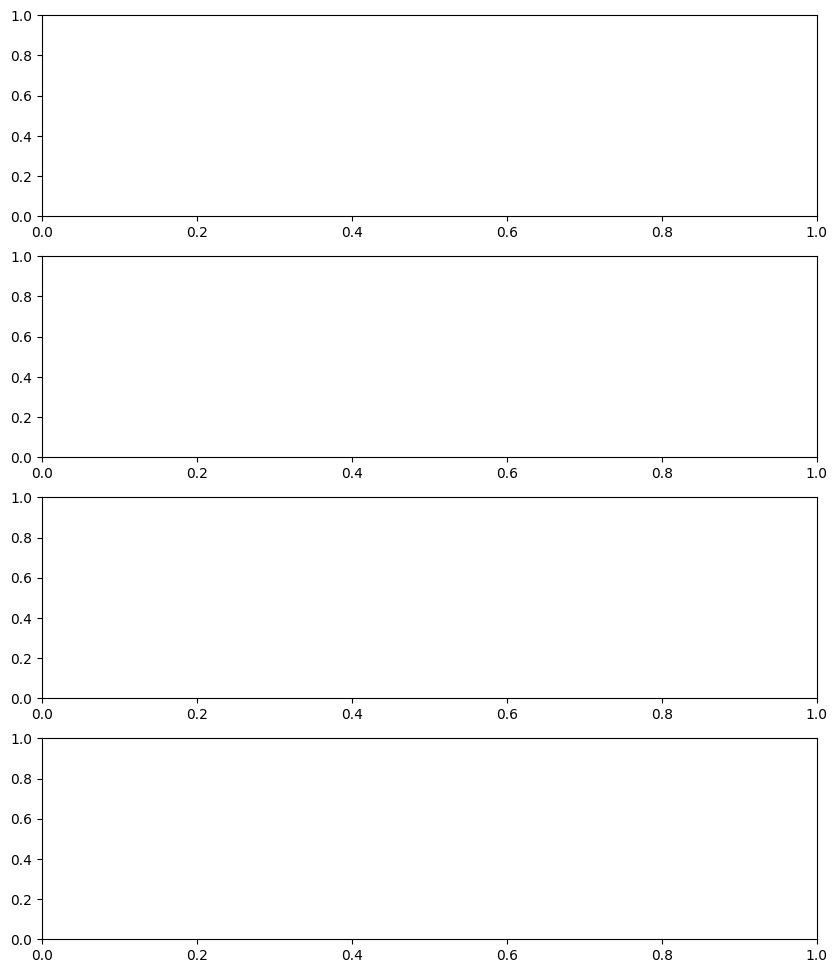

In [ ]:
plot_graphs(tmax, dt, V, Z, M, Thrust, grav, Rho, T, P, Drag)

###Generating Corrupted, Noisy, Anomaly samples




In [ ]:
def generating_anomaly_samples(num_samples = 100):

    """
    This function generating same trajectory as the first function but with diffrent:
    It creates anomaly samples by gaussian_noise and set the noise_factor to 0.98
    """

    for i in range(num_samples):
      FT = 560000  # rocket thrust, in Newtons
      d = 1.7  # rocket diameter, in meters
      A = np.pi * (d / 2) ** 2  # rocket cross-sectional area
      L = 0  # rocket length, in meters
      empty = 3120  # mass when fuel is expended, in kg ("dry mass")
      Isp = 221  # specific impulse, in seconds
      dm = FT / (g0 * Isp)  # mass flow rate, dm/dt

      # Initial Conditions
      m0 = 46760  # initial mass, in kg ("wet mass")
      C0 = 0.75  # drag coefficient
      z0 = 1  # initial altitude
      v0 = 0  # initial velocity

      # Euler-Cromer Method
      dt = 0.1  # time step

      v = v0
      z = z0
      V = [v]
      Z = [z]
      m = m0
      Rho = [rho0]
      T = [T0]
      P = [P0]
      M = [m]
      Thrust = [FT / m]
      Drag = [0]
      g = g0
      grav = [g]

      nextstage = 0
      tmax = 500

      print(f"Starting with sample #{i}")
      for t in np.arange(dt, tmax + dt, dt):
          g = (G * M_earth) / ((z + r) ** 2)  # gravitational acceleration, g(z)
          m = m - (dm * dt)  # changing mass, m(t)
          rho, temp, press = density(z)
          rho, temp, press = gaussian_noise(rho, temp, press)

          # changing air density by barometric formula, rho(z)
          Cd = gaussian_noise(drag_coefficient(v, temp), noise_factor=0.98)[0]  # Drag coefficient.

          thrust = FT / m
          drag = 0.5 * rho * (v ** 2) * Cd * A / m

          if v < 0:  # flip drag force vector if rocket falls
              drag = drag * -1

          v = v + (thrust - drag - g) * dt  # new velocity
          z = z + v * dt  # new altitude

          V.append(v)
          Z.append(z)
          M.append(m)
          grav.append(g)
          Thrust.append(thrust)
          Drag.append(drag)
          Rho.append(rho)
          T.append(temp)
          P.append(press)

          if z < 0:  # rocket crashes or fails to launch
              break
          elif m < empty:  # rocket runs out of fuel, mass becomes stable
              FT = 0
              dm = 0
              nextstage += 1

      data = {
          'Velocity[m/s]': V,
          'Altitude[m]': Z,
          'Thrust[N]': Thrust,
          'gravitation [m/s^2]': grav,
          'Temperature[K]': T,
          'Pressure[PSI]': P,
          'Drag[N]': Drag,
          'Mass[Kg]': M,
          'Density': Rho,
          'Label': 0
      }
      try:
          save_data_to_csv(data, f"dataset/{2000 + i}.csv", "MyDatasetFolder")
          print(f"Dataset {2000 + i} saved successfully.")
      except Exception as e:
          print(f"Failed to save dataset {2000 + i}. Error: {e}")


generating_anomaly_samples(500)

###Plot the graphs of an example of a noisy samples


In [ ]:
plot_graphs(tmax, dt, V, Z, M, Thrust, grav, Rho, T, P, Drag)